In [ ]:
# Import packages
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [14]:
# Import data set 
df = pd.read_csv("dat_nn.csv")

In [ ]:
# Format data 
# Check that you have exactly 101 items per subject per signal
assert df.groupby(['subject', 'signal_components']).size().nunique() == 1, "Inconsistent item count"

# Create a time-indexed variable name: X_1, X_2, ..., Y_101
df['feature_name'] = df['signal_components'] + "_" + df['item'].astype(str)

# Pivot: one row per subject, columns = feature_name
df_wide = df.pivot(index='subject', columns='feature_name', values='value').reset_index()

# Merge in group label (for classification)
labels = df[['subject', 'group']].drop_duplicates()
df_final = df_wide.merge(labels, on='subject')

In [16]:
# Investigate Assertion Error (if any)
df.groupby(['subject', 'signal_components']).size().reset_index(name='count').query("count != 101")

,subject,signal_components,count


In [ ]:
# Split into features and labels 
X = df_final.drop(columns=['subject', 'group']).to_numpy()  # shape (n_subjects, 202)
y = df_final['group'].to_numpy()  # shape (n_subjects,)

In [18]:
# Split into trainging and test sets by subject 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# Explore Dataset
m_train = X_train.shape[0]
num_px = X_train.shape[1]
m_test = X_test.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each subject is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(X_train.shape))
print ("train_y shape: " + str(y_train.shape))
print ("test_x_orig shape: " + str(X_test.shape))
print ("test_y shape: " + str(y_test.shape))

Number of training examples: 110
Number of testing examples: 28
Each subject is of size: (202, 202, 3)
train_x_orig shape: (110, 202)
train_y shape: (110,)
test_x_orig shape: (28, 202)
test_y shape: (28,)


In [ ]:
# Plot Data 


In [24]:
# Import Neural Netowrk Code 
from gait_NN_classifier_July28 import * 

In [34]:
# Train the Model 
def run_gait_classification_pipeline():
    """Complete pipeline for gait classification"""
    
    print("\n=== Starting Gait Waveform Classification ===")
    
    # Define network architecture
    # Input: 202 features (101 frontal + 101 sagittal gait points)
    # Hidden layers: progressively smaller
    # Output: 1 neuron for binary classification
    layers_dims = [202, 128, 64, 32, 16, 1]
    
    # Hyperparameters - you can experiment with these
    learning_rate = 0.01    # Start with 0.01, can try 0.005 or 0.02
    num_iterations = 2500   # Can increase if underfitting
    lambd = 0.01           # L2 regularization to prevent overfitting
    
    # Train the model
    parameters, scaler, costs = train_gait_classifier(
        X_train, X_test, y_train, y_test,
        layers_dims=layers_dims,
        learning_rate=learning_rate,
        num_iterations=num_iterations,
        lambd=lambd
    )

    # Feature Importance Analysis 
    print("\n=== Feature Importance Analysis ===")
    feature_names = df_final.drop(columns=['subject', 'group']).columns.tolist()
    importance_df = analyze_feature_importance(parameters, feature_names)

    # Show top 10 most important features
    print("\nTop 10 Most Important Features:")
    print(importance_df.head(10))

    # Frontal vs Sagittal Plane Importance
    frontal_features = [f for f in feature_names if f.startswith('X_')]
    sagittal_features = [f for f in feature_names if f.startswith('Y_')]

    frontal_importance = importance_df[importance_df['feature'].isin(frontal_features)]['importance'].mean()
    sagittal_importance = importance_df[importance_df['feature'].isin(sagittal_features)]['importance'].mean()

    print(f"\nAverage Frontal Plane Feature Importance: {frontal_importance:.4f}")
    print(f"Average Sagittal Plane Feature Importance: {sagittal_importance:.4f}")

    # Test on New Data 
    def predict_new_subject(new_data, parameters, scaler):
        """
        Predict knee OA for a new subject
        
        Arguments:
        new_data -- numpy array of shape (202,) with gait features
        parameters -- trained model parameters
        scaler -- fitted StandardScaler from training
        
        Returns:
        prediction -- 0 (healthy) or 1 (OA)
        probability -- probability of having OA
        """
        # Preprocess the new data
        new_data_scaled = scaler.transform(new_data.reshape(1, -1))
        new_data_formatted = new_data_scaled.T
        
        # Make prediction
        prediction, probability = predict(new_data_formatted, parameters)
        
        return prediction[0, 0], probability[0, 0]
    
    # Example usage (uncomment when you have new data):
    # new_subject_data = np.random.randn(202)  # Replace with actual data
    # pred, prob = predict_new_subject(new_subject_data, parameters, scaler)
    # print(f"Prediction: {'OA' if pred == 1 else 'Healthy'}, Probability: {prob:.3f}")
    
    return parameters, scaler, costs, importance_df


In [36]:
# Model Validation and Improvement 
def hyperparameter_search():
    """
    Perform simple hyperparameter search to find optimal settings
    """
    
    print("\n=== Hyperparameter Search ===")
    
    # Define parameter grid
    learning_rates = [0.005, 0.01, 0.02]
    regularization_params = [0.0, 0.01, 0.05]
    architectures = [
        [202, 128, 64, 1],      # Shallow
        [202, 128, 64, 32, 1],  # Medium
        [202, 128, 64, 32, 16, 1]  # Deep
    ]
    
    best_accuracy = 0
    best_params = {}
    results = []
    
    for lr in learning_rates:
        for lambd in regularization_params:
            for arch in architectures:
                print(f"\nTesting: LR={lr}, L2={lambd}, Architecture={arch}")
                
                try:
                    # Train model with current parameters
                    parameters, scaler, costs = train_gait_classifier(
                        X_train, X_test, y_train, y_test,
                        layers_dims=arch,
                        learning_rate=lr,
                        num_iterations=1500,  # Reduced for faster search
                        lambd=lambd
                    )
                    
                    # Evaluate performance
                    X_test_proc, _, y_test_proc, _, _ = preprocess_gait_data(
                        X_train, X_test, y_train, y_test
                    )
                    test_accuracy, test_auc, _, _ = evaluate_model(X_test_proc, y_test_proc, parameters)
                    
                    # Store results
                    result = {
                        'learning_rate': lr,
                        'lambda': lambd,
                        'architecture': arch,
                        'test_accuracy': test_accuracy,
                        'test_auc': test_auc
                    }
                    results.append(result)
                    
                    # Check if this is the best so far
                    if test_accuracy > best_accuracy:
                        best_accuracy = test_accuracy
                        best_params = result.copy()
                        
                    print(f"Test Accuracy: {test_accuracy:.2f}%, AUC: {test_auc:.4f}")
                    
                except Exception as e:
                    print(f"Error with parameters: {e}")
                    continue
    
    print(f"\n=== Best Parameters Found ===")
    print(f"Best Test Accuracy: {best_accuracy:.2f}%")
    print(f"Best Parameters: {best_params}")
    
    # Convert results to DataFrame for easy analysis
    results_df = pd.DataFrame(results)
    return results_df, best_params

In [37]:
# Cross Validation 
def cross_validate_model(n_splits=5):
    """
    Perform stratified k-fold cross-validation
    """
    from sklearn.model_selection import StratifiedKFold
    
    print(f"\n=== {n_splits}-Fold Cross-Validation ===")
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    cv_accuracies = []
    cv_aucs = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"\nFold {fold + 1}/{n_splits}")
        
        X_train_cv, X_val_cv = X[train_idx], X[val_idx]
        y_train_cv, y_val_cv = y[train_idx], y[val_idx]
        
        # Train model
        parameters, scaler, _ = train_gait_classifier(
            X_train_cv, X_val_cv, y_train_cv, y_val_cv,
            layers_dims=[202, 128, 64, 32, 1],
            learning_rate=0.01,
            num_iterations=2000,
            lambd=0.01
        )
        
        # Evaluate
        X_val_proc, _, y_val_proc, _, _ = preprocess_gait_data(
            X_train_cv, X_val_cv, y_train_cv, y_val_cv
        )
        val_accuracy, val_auc, _, _ = evaluate_model(X_val_proc, y_val_proc, parameters)
        
        cv_accuracies.append(val_accuracy)
        cv_aucs.append(val_auc)
        
        print(f"Fold {fold + 1} - Accuracy: {val_accuracy:.2f}%, AUC: {val_auc:.4f}")
    
    print(f"\n=== Cross-Validation Results ===")
    print(f"Mean Accuracy: {np.mean(cv_accuracies):.2f}% ± {np.std(cv_accuracies):.2f}%")
    print(f"Mean AUC: {np.mean(cv_aucs):.4f} ± {np.std(cv_aucs):.4f}")
    
    return cv_accuracies, cv_aucs

In [40]:
# Additional Analyses
def analyze_gait_patterns(parameters, scaler, X_train, y_train):
    """
    Analyze what gait patterns the model has learned
    """
    print("\n=== Gait Pattern Analysis ===")
    
    # Get feature names
    feature_names = df_final.drop(columns=['subject', 'group']).columns.tolist()
    
    # Separate frontal and sagittal features
    frontal_features = [f for f in feature_names if f.startswith('X_')]
    sagittal_features = [f for f in feature_names if f.startswith('Y_')]
    
    # Get average patterns for each group
    X_train_scaled = scaler.transform(X_train)
    
    healthy_mask = y_train == '0'  # Adjust based on your labels
    oa_mask = y_train == '1'  # Adjust based on your labels
    
    healthy_avg = X_train_scaled[healthy_mask].mean(axis=0)
    oa_avg = X_train_scaled[oa_mask].mean(axis=0)
    
    # Plot average gait patterns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Frontal plane (first 101 features)
    ax1.plot(healthy_avg[:101], label='Healthy', color='blue', alpha=0.7)
    ax1.plot(oa_avg[:101], label='OA', color='red', alpha=0.7)
    ax1.set_title('Average Frontal Plane Gait Pattern')
    ax1.set_xlabel('Gait Cycle (%)')
    ax1.set_ylabel('Normalized Amplitude')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Sagittal plane (next 101 features)
    ax2.plot(healthy_avg[101:], label='Healthy', color='blue', alpha=0.7)
    ax2.plot(oa_avg[101:], label='OA', color='red', alpha=0.7)
    ax2.set_title('Average Sagittal Plane Gait Pattern')
    ax2.set_xlabel('Gait Cycle (%)')
    ax2.set_ylabel('Normalized Amplitude')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate differences
    difference_frontal = oa_avg[:101] - healthy_avg[:101]
    difference_sagittal = oa_avg[101:] - healthy_avg[101:]
    
    # Plot differences
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    ax1.plot(difference_frontal, color='purple', linewidth=2)
    ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax1.set_title('Difference in Frontal Plane (OA - Healthy)')
    ax1.set_xlabel('Gait Cycle (%)')
    ax1.set_ylabel('Amplitude Difference')
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(difference_sagittal, color='orange', linewidth=2)
    ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax2.set_title('Difference in Sagittal Plane (OA - Healthy)')
    ax2.set_xlabel('Gait Cycle (%)')
    ax2.set_ylabel('Amplitude Difference')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return healthy_avg, oa_avg, difference_frontal, difference_sagittal

def plot_learning_curves_comparison(results_list, labels):
    """
    Compare learning curves from different model configurations
    """
    plt.figure(figsize=(12, 8))
    
    for costs, label in zip(results_list, labels):
        plt.plot(costs, label=label, linewidth=2)
    
    plt.xlabel('Iterations (per hundreds)')
    plt.ylabel('Cost')
    plt.title('Learning Curves Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def generate_model_report(parameters, scaler, costs, importance_df, 
                         test_accuracy, test_auc, cv_results=None):
    """
    Generate a comprehensive model report
    """
    print("\n" + "="*60)
    print("           GAIT WAVEFORM CLASSIFICATION REPORT")
    print("="*60)
    
    # Model Architecture
    L = len(parameters) // 2
    print(f"\nMODEL ARCHITECTURE:")
    print(f"  - Number of layers: {L}")
    print(f"  - Input features: {parameters['W1'].shape[1]}")
    for i in range(1, L):
        print(f"  - Hidden layer {i}: {parameters[f'W{i}'].shape[0]} neurons")
    print(f"  - Output layer: {parameters[f'W{L}'].shape[0]} neuron(s)")
    
    # Training Performance
    print(f"\nTRAINING PERFORMANCE:")
    print(f"  - Final training cost: {costs[-1]:.6f}")
    print(f"  - Training converged: {'Yes' if costs[-1] < costs[0] * 0.1 else 'No'}")
    
    # Test Performance
    print(f"\nTEST PERFORMANCE:")
    print(f"  - Test Accuracy: {test_accuracy:.2f}%")
    print(f"  - Test AUC: {test_auc:.4f}")
    
    # Cross-validation (if available)
    if cv_results:
        cv_acc, cv_auc = cv_results
        print(f"\nCROSS-VALIDATION RESULTS:")
        print(f"  - Mean CV Accuracy: {np.mean(cv_acc):.2f}% ± {np.std(cv_acc):.2f}%")
        print(f"  - Mean CV AUC: {np.mean(cv_auc):.4f} ± {np.std(cv_auc):.4f}")
    
    # Feature Importance
    print(f"\nFEATURE IMPORTANCE:")
    frontal_features = [f for f in importance_df['feature'] if f.startswith('X_')]
    sagittal_features = [f for f in importance_df['feature'] if f.startswith('Y_')]
    
    frontal_importance = importance_df[importance_df['feature'].isin(frontal_features)]['importance'].mean()
    sagittal_importance = importance_df[importance_df['feature'].isin(sagittal_features)]['importance'].mean()
    
    print(f"  - Average frontal plane importance: {frontal_importance:.4f}")
    print(f"  - Average sagittal plane importance: {sagittal_importance:.4f}")
    print(f"  - Most important plane: {'Frontal' if frontal_importance > sagittal_importance else 'Sagittal'}")
    
    print(f"\nTOP 5 MOST IMPORTANT FEATURES:")
    for i, row in importance_df.head(5).iterrows():
        plane = "Frontal" if row['feature'].startswith('X_') else "Sagittal"
        time_point = row['feature'].split('_')[1]
        print(f"  {i+1}. {row['feature']} ({plane} plane, {time_point}% gait cycle) - {row['importance']:.4f}")
    
    print("\n" + "="*60)

Starting Gait Waveform Classification Analysis...

### STEP 1: Basic Model Training ###

=== Starting Gait Waveform Classification ===
=== Gait Waveform Classification with Deep Neural Network ===

Preprocessing data...
Training set: 110 examples
Test set: 28 examples
Features: 202

Network architecture: [202, 128, 64, 32, 16, 1]
Learning rate: 0.01
Iterations: 2500
L2 regularization parameter: 0.01

Training model...
Cost after iteration 0: 0.880179
Cost after iteration 100: 0.189957
Cost after iteration 200: 0.109004
Cost after iteration 300: 0.077651
Cost after iteration 400: 0.061116
Cost after iteration 500: 0.051940
Cost after iteration 600: 0.043558
Cost after iteration 700: 0.038025
Cost after iteration 800: 0.034739
Cost after iteration 900: 0.032384
Cost after iteration 1000: 0.030698
Cost after iteration 1100: 0.029449
Cost after iteration 1200: 0.028481
Cost after iteration 1300: 0.027717
Cost after iteration 1400: 0.027104
Cost after iteration 1500: 0.026608
Cost after ite

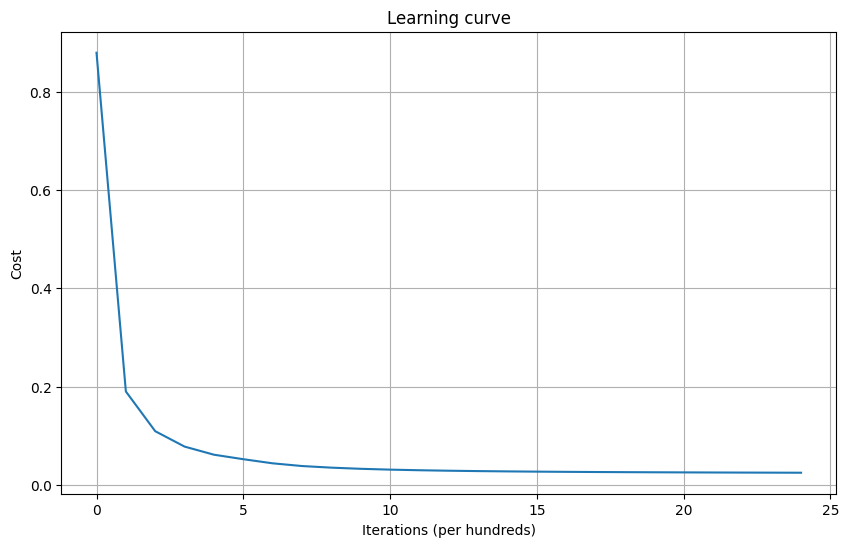


=== Training Set Performance ===
Training Accuracy: 100.00%
Training AUC: 1.0000

=== Test Set Performance ===
Test Accuracy: 89.29%
Test AUC: 0.9792

=== Detailed Classification Report ===
              precision    recall  f1-score   support

     Healthy       0.57      1.00      0.73         4
          OA       1.00      0.88      0.93        24

    accuracy                           0.89        28
   macro avg       0.79      0.94      0.83        28
weighted avg       0.94      0.89      0.90        28



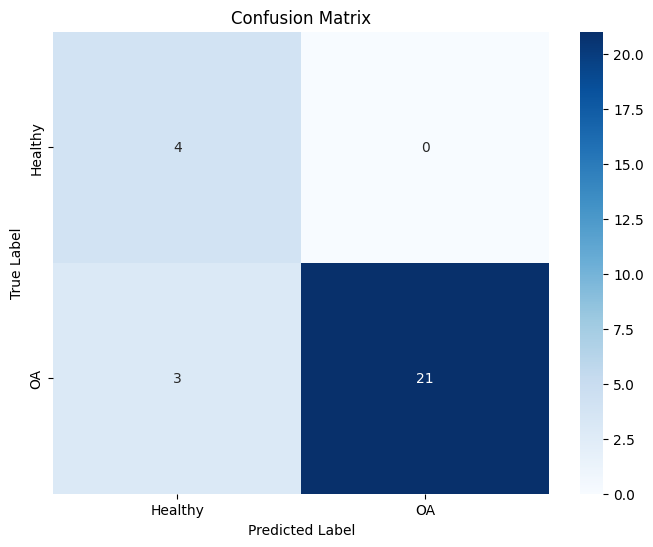


=== Feature Importance Analysis ===


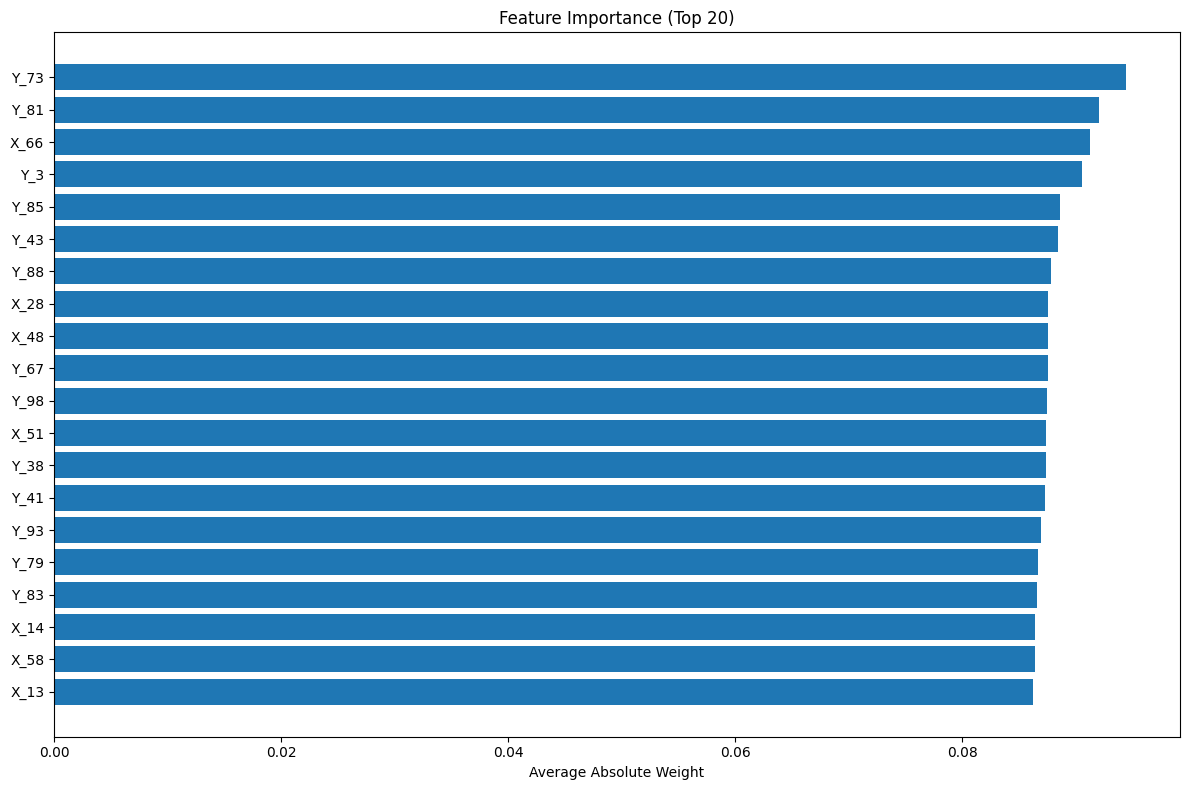


Top 10 Most Important Features:
    feature  importance
173    Y_73    0.094450
182    Y_81    0.092062
64     X_66    0.091214
125     Y_3    0.090522
186    Y_85    0.088584
140    Y_43    0.088406
189    Y_88    0.087841
22     X_28    0.087562
44     X_48    0.087539
166    Y_67    0.087534

Average Frontal Plane Feature Importance: 0.0793
Average Sagittal Plane Feature Importance: 0.0790

### STEP 2: Cross-Validation ###

=== 5-Fold Cross-Validation ===

Fold 1/5
=== Gait Waveform Classification with Deep Neural Network ===

Preprocessing data...
Training set: 110 examples
Test set: 28 examples
Features: 202

Network architecture: [202, 128, 64, 32, 1]
Learning rate: 0.01
Iterations: 2000
L2 regularization parameter: 0.01

Training model...
Cost after iteration 0: 0.780077
Cost after iteration 100: 0.242038
Cost after iteration 200: 0.174957
Cost after iteration 300: 0.136606
Cost after iteration 400: 0.109677
Cost after iteration 500: 0.090328
Cost after iteration 600: 0.075577


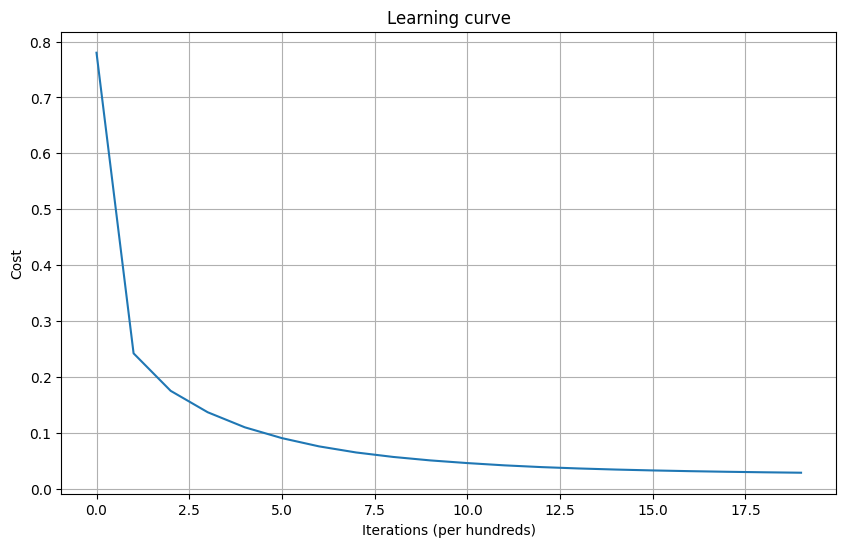


=== Training Set Performance ===
Training Accuracy: 100.00%
Training AUC: 1.0000

=== Test Set Performance ===
Test Accuracy: 96.43%
Test AUC: 0.9739

=== Detailed Classification Report ===
              precision    recall  f1-score   support

     Healthy       0.83      1.00      0.91         5
          OA       1.00      0.96      0.98        23

    accuracy                           0.96        28
   macro avg       0.92      0.98      0.94        28
weighted avg       0.97      0.96      0.97        28



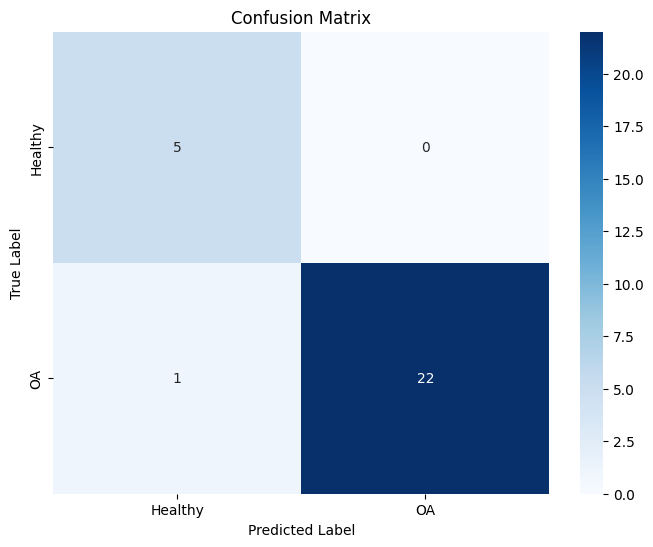

Fold 1 - Accuracy: 100.00%, AUC: 1.0000

Fold 2/5
=== Gait Waveform Classification with Deep Neural Network ===

Preprocessing data...
Training set: 110 examples
Test set: 28 examples
Features: 202

Network architecture: [202, 128, 64, 32, 1]
Learning rate: 0.01
Iterations: 2000
L2 regularization parameter: 0.01

Training model...
Cost after iteration 0: 0.804579
Cost after iteration 100: 0.194015
Cost after iteration 200: 0.137902
Cost after iteration 300: 0.106948
Cost after iteration 400: 0.087367
Cost after iteration 500: 0.074134
Cost after iteration 600: 0.064734
Cost after iteration 700: 0.057756
Cost after iteration 800: 0.052328
Cost after iteration 900: 0.048011
Cost after iteration 1000: 0.043489
Cost after iteration 1100: 0.040010
Cost after iteration 1200: 0.037284
Cost after iteration 1300: 0.035087
Cost after iteration 1400: 0.033290
Cost after iteration 1500: 0.031805
Cost after iteration 1600: 0.030562
Cost after iteration 1700: 0.029518
Cost after iteration 1800: 0.02

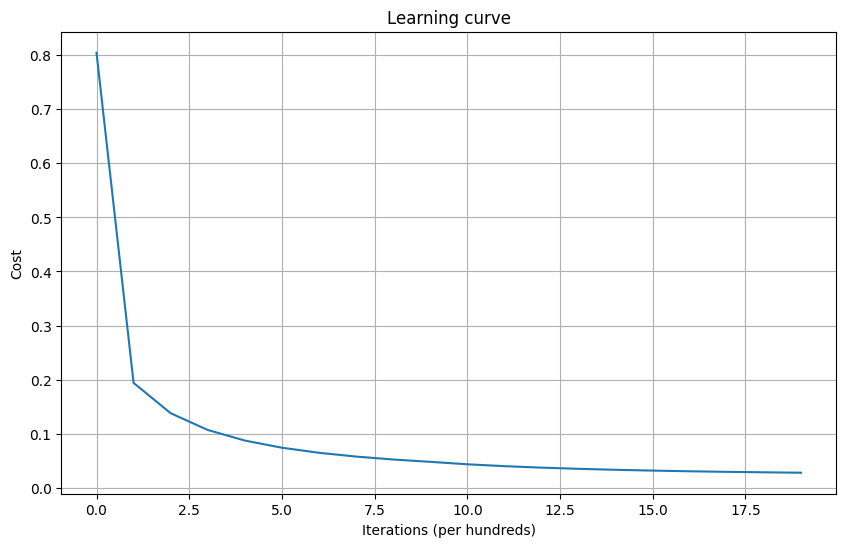


=== Training Set Performance ===
Training Accuracy: 100.00%
Training AUC: 1.0000

=== Test Set Performance ===
Test Accuracy: 78.57%
Test AUC: 0.7304

=== Detailed Classification Report ===
              precision    recall  f1-score   support

     Healthy       0.00      0.00      0.00         5
          OA       0.81      0.96      0.88        23

    accuracy                           0.79        28
   macro avg       0.41      0.48      0.44        28
weighted avg       0.67      0.79      0.72        28



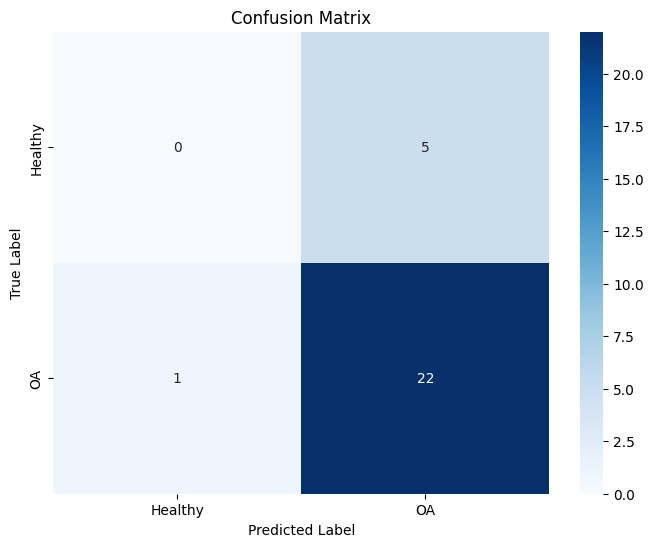

Fold 2 - Accuracy: 100.00%, AUC: 1.0000

Fold 3/5
=== Gait Waveform Classification with Deep Neural Network ===

Preprocessing data...
Training set: 110 examples
Test set: 28 examples
Features: 202

Network architecture: [202, 128, 64, 32, 1]
Learning rate: 0.01
Iterations: 2000
L2 regularization parameter: 0.01

Training model...
Cost after iteration 0: 0.803685
Cost after iteration 100: 0.166489
Cost after iteration 200: 0.113571
Cost after iteration 300: 0.090546
Cost after iteration 400: 0.077377
Cost after iteration 500: 0.068360
Cost after iteration 600: 0.061690
Cost after iteration 700: 0.056731
Cost after iteration 800: 0.052829
Cost after iteration 900: 0.049650
Cost after iteration 1000: 0.047003
Cost after iteration 1100: 0.044719
Cost after iteration 1200: 0.042722
Cost after iteration 1300: 0.040985
Cost after iteration 1400: 0.039426
Cost after iteration 1500: 0.038012
Cost after iteration 1600: 0.036721
Cost after iteration 1700: 0.035550
Cost after iteration 1800: 0.03

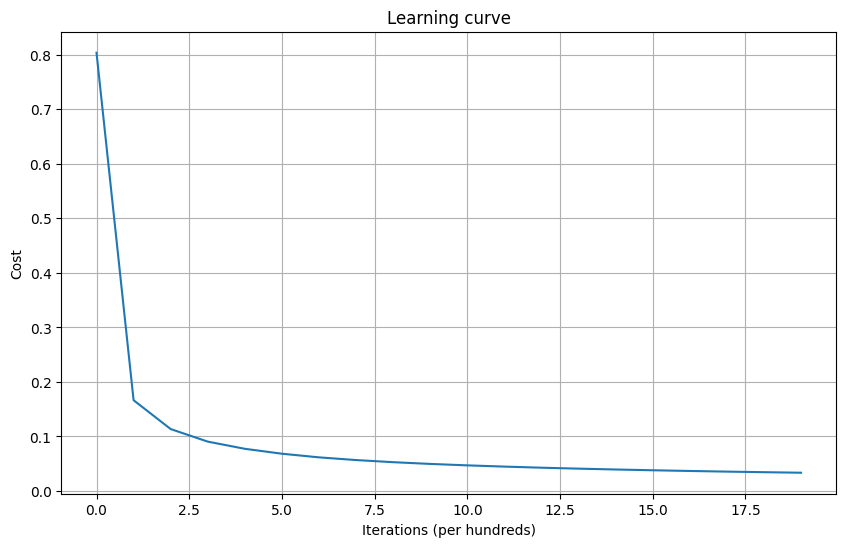


=== Training Set Performance ===
Training Accuracy: 100.00%
Training AUC: 1.0000

=== Test Set Performance ===
Test Accuracy: 78.57%
Test AUC: 0.8174

=== Detailed Classification Report ===
              precision    recall  f1-score   support

     Healthy       0.44      0.80      0.57         5
          OA       0.95      0.78      0.86        23

    accuracy                           0.79        28
   macro avg       0.70      0.79      0.71        28
weighted avg       0.86      0.79      0.81        28



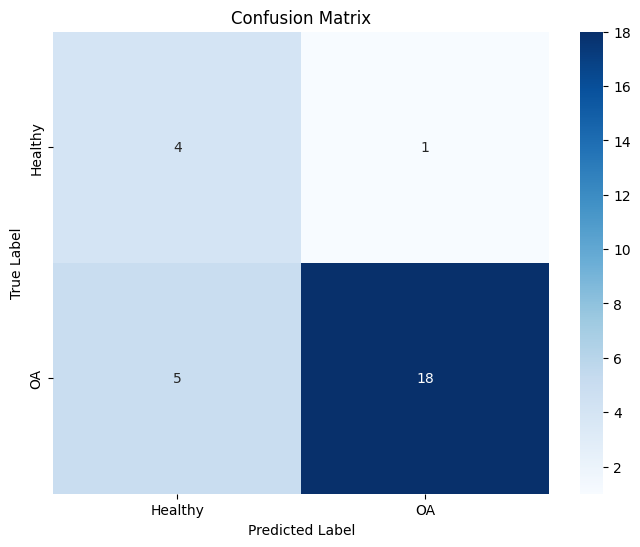

Fold 3 - Accuracy: 100.00%, AUC: 1.0000

Fold 4/5
=== Gait Waveform Classification with Deep Neural Network ===

Preprocessing data...
Training set: 111 examples
Test set: 27 examples
Features: 202

Network architecture: [202, 128, 64, 32, 1]
Learning rate: 0.01
Iterations: 2000
L2 regularization parameter: 0.01

Training model...
Cost after iteration 0: 0.795968
Cost after iteration 100: 0.246713
Cost after iteration 200: 0.184649
Cost after iteration 300: 0.148031
Cost after iteration 400: 0.121925
Cost after iteration 500: 0.102546
Cost after iteration 600: 0.087632
Cost after iteration 700: 0.075410
Cost after iteration 800: 0.065951
Cost after iteration 900: 0.058536
Cost after iteration 1000: 0.052724
Cost after iteration 1100: 0.048183
Cost after iteration 1200: 0.044666
Cost after iteration 1300: 0.041832
Cost after iteration 1400: 0.039284
Cost after iteration 1500: 0.037111
Cost after iteration 1600: 0.035316
Cost after iteration 1700: 0.033794
Cost after iteration 1800: 0.03

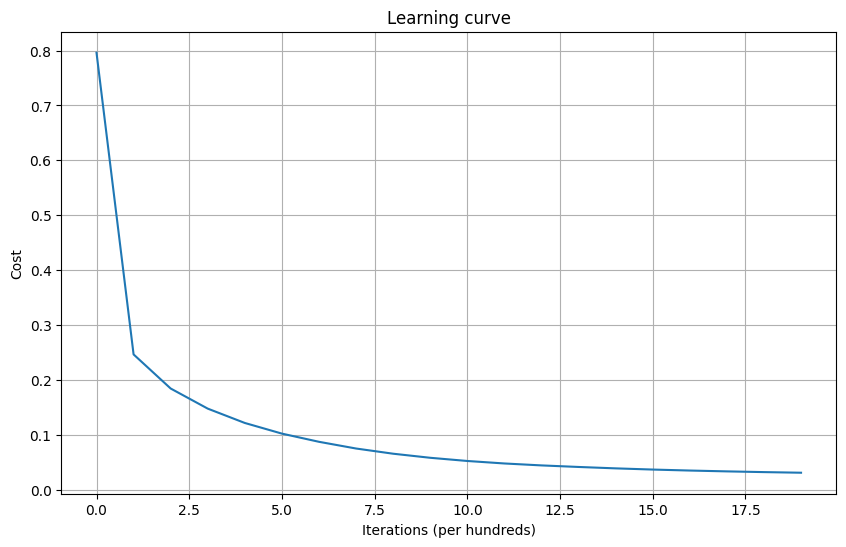


=== Training Set Performance ===
Training Accuracy: 100.00%
Training AUC: 1.0000

=== Test Set Performance ===
Test Accuracy: 92.59%
Test AUC: 0.9674

=== Detailed Classification Report ===
              precision    recall  f1-score   support

     Healthy       1.00      0.50      0.67         4
          OA       0.92      1.00      0.96        23

    accuracy                           0.93        27
   macro avg       0.96      0.75      0.81        27
weighted avg       0.93      0.93      0.92        27



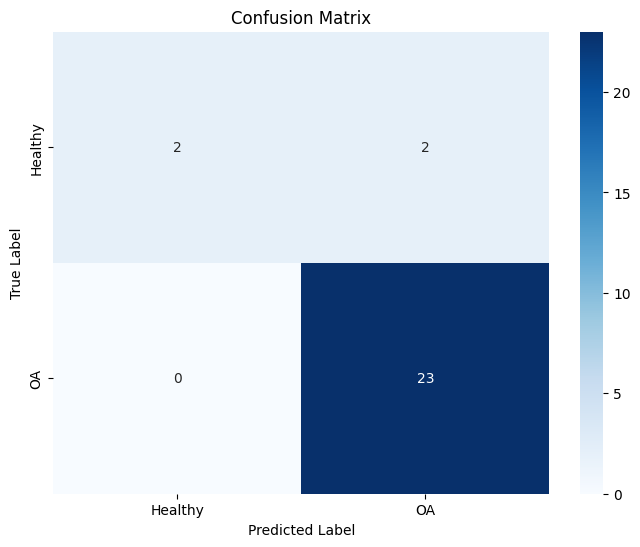

Fold 4 - Accuracy: 100.00%, AUC: 1.0000

Fold 5/5
=== Gait Waveform Classification with Deep Neural Network ===

Preprocessing data...
Training set: 111 examples
Test set: 27 examples
Features: 202

Network architecture: [202, 128, 64, 32, 1]
Learning rate: 0.01
Iterations: 2000
L2 regularization parameter: 0.01

Training model...
Cost after iteration 0: 0.796459
Cost after iteration 100: 0.235863
Cost after iteration 200: 0.169704
Cost after iteration 300: 0.132907
Cost after iteration 400: 0.107821
Cost after iteration 500: 0.090006
Cost after iteration 600: 0.076598
Cost after iteration 700: 0.065352
Cost after iteration 800: 0.057192
Cost after iteration 900: 0.050962
Cost after iteration 1000: 0.046132
Cost after iteration 1100: 0.042329
Cost after iteration 1200: 0.039270
Cost after iteration 1300: 0.036863
Cost after iteration 1400: 0.034976
Cost after iteration 1500: 0.033420
Cost after iteration 1600: 0.032135
Cost after iteration 1700: 0.031056
Cost after iteration 1800: 0.03

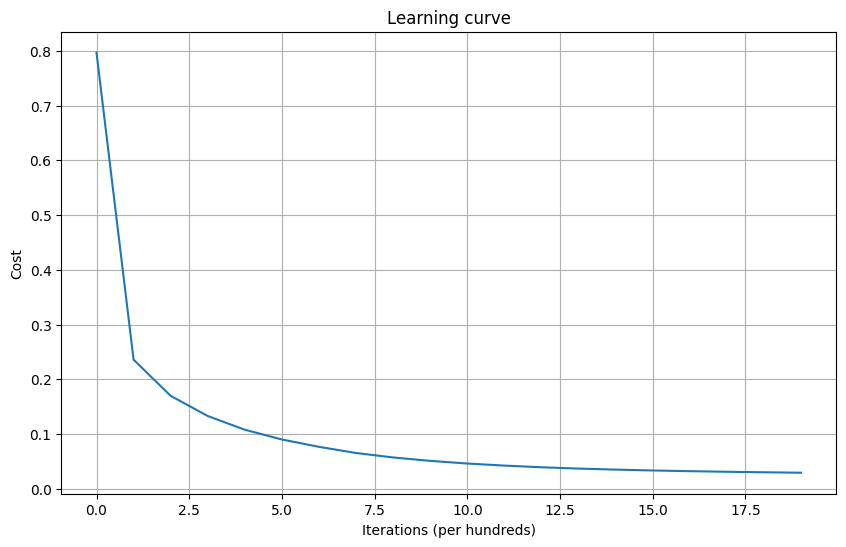


=== Training Set Performance ===
Training Accuracy: 100.00%
Training AUC: 1.0000

=== Test Set Performance ===
Test Accuracy: 88.89%
Test AUC: 0.8455

=== Detailed Classification Report ===
              precision    recall  f1-score   support

     Healthy       0.75      0.60      0.67         5
          OA       0.91      0.95      0.93        22

    accuracy                           0.89        27
   macro avg       0.83      0.78      0.80        27
weighted avg       0.88      0.89      0.88        27



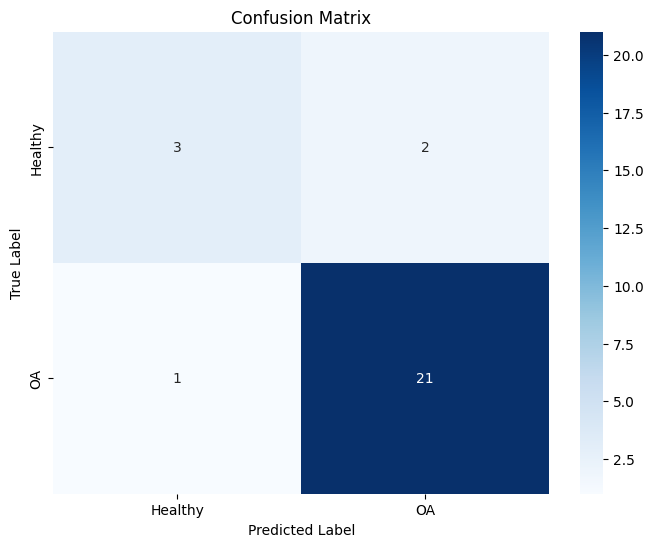

Fold 5 - Accuracy: 100.00%, AUC: 1.0000

=== Cross-Validation Results ===
Mean Accuracy: 100.00% ± 0.00%
Mean AUC: 1.0000 ± 0.0000

### STEP 3: Hyperparameter Search ###

=== Hyperparameter Search ===

Testing: LR=0.005, L2=0.0, Architecture=[202, 128, 64, 1]
=== Gait Waveform Classification with Deep Neural Network ===

Preprocessing data...
Training set: 110 examples
Test set: 28 examples
Features: 202

Network architecture: [202, 128, 64, 1]
Learning rate: 0.005
Iterations: 1500
L2 regularization parameter: 0.0

Training model...
Cost after iteration 0: 0.671684
Cost after iteration 100: 0.246341
Cost after iteration 200: 0.189842
Cost after iteration 300: 0.160296
Cost after iteration 400: 0.140174
Cost after iteration 500: 0.124938
Cost after iteration 600: 0.112990
Cost after iteration 700: 0.102758
Cost after iteration 800: 0.093881
Cost after iteration 900: 0.085965
Cost after iteration 1000: 0.079124
Cost after iteration 1100: 0.073087
Cost after iteration 1200: 0.067720
Cost 

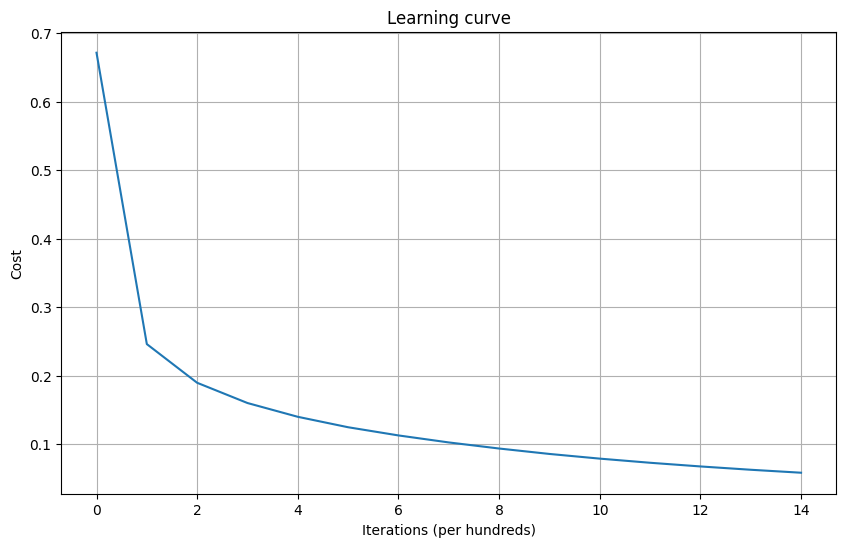


=== Training Set Performance ===
Training Accuracy: 99.09%
Training AUC: 0.9994

=== Test Set Performance ===
Test Accuracy: 89.29%
Test AUC: 0.9167

=== Detailed Classification Report ===
              precision    recall  f1-score   support

     Healthy       0.57      1.00      0.73         4
          OA       1.00      0.88      0.93        24

    accuracy                           0.89        28
   macro avg       0.79      0.94      0.83        28
weighted avg       0.94      0.89      0.90        28



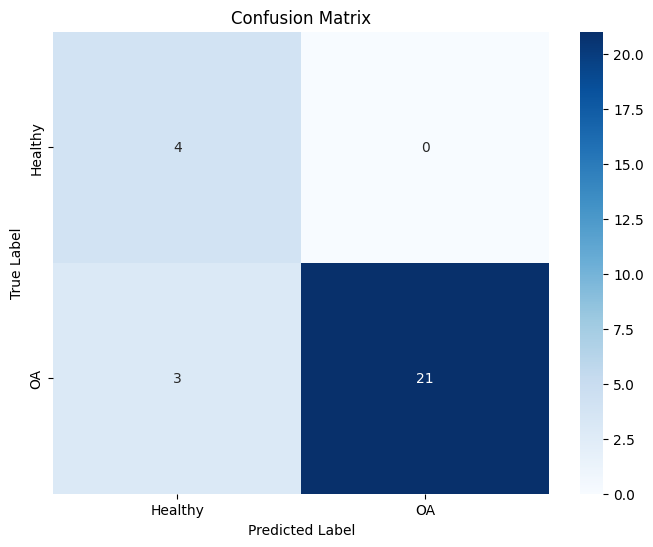

Test Accuracy: 99.09%, AUC: 0.9994

Testing: LR=0.005, L2=0.0, Architecture=[202, 128, 64, 32, 1]
=== Gait Waveform Classification with Deep Neural Network ===

Preprocessing data...
Training set: 110 examples
Test set: 28 examples
Features: 202

Network architecture: [202, 128, 64, 32, 1]
Learning rate: 0.005
Iterations: 1500
L2 regularization parameter: 0.0

Training model...
Cost after iteration 0: 0.763549
Cost after iteration 100: 0.258494
Cost after iteration 200: 0.186219
Cost after iteration 300: 0.149882
Cost after iteration 400: 0.125972
Cost after iteration 500: 0.108117
Cost after iteration 600: 0.094073
Cost after iteration 700: 0.082542
Cost after iteration 800: 0.072965
Cost after iteration 900: 0.065287
Cost after iteration 1000: 0.058832
Cost after iteration 1100: 0.053412
Cost after iteration 1200: 0.048490
Cost after iteration 1300: 0.044049
Cost after iteration 1400: 0.040199


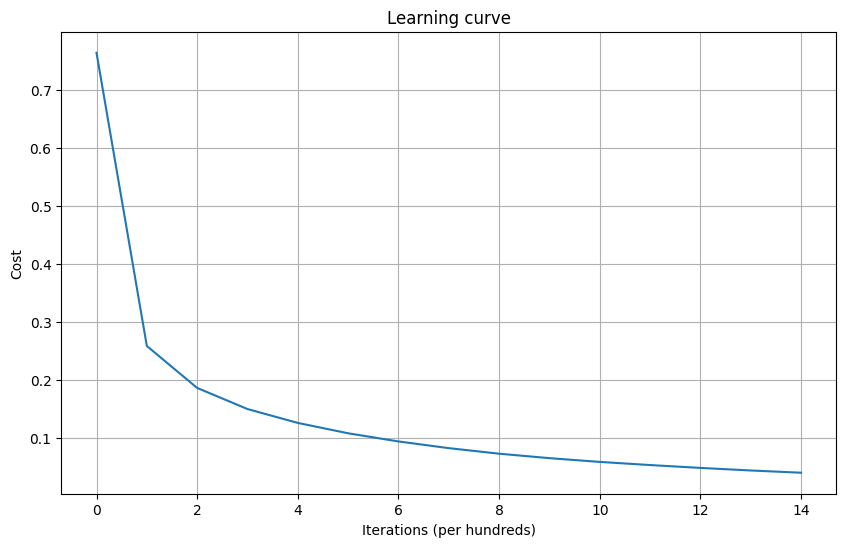


=== Training Set Performance ===
Training Accuracy: 99.09%
Training AUC: 0.9994

=== Test Set Performance ===
Test Accuracy: 89.29%
Test AUC: 0.9479

=== Detailed Classification Report ===
              precision    recall  f1-score   support

     Healthy       0.57      1.00      0.73         4
          OA       1.00      0.88      0.93        24

    accuracy                           0.89        28
   macro avg       0.79      0.94      0.83        28
weighted avg       0.94      0.89      0.90        28



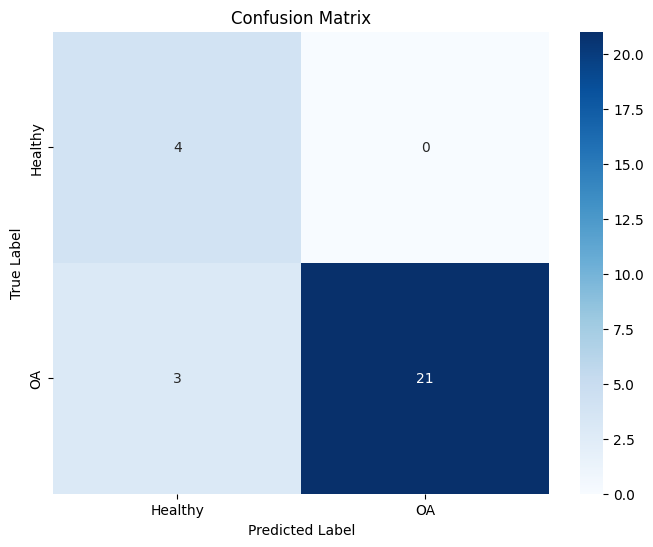

Test Accuracy: 99.09%, AUC: 0.9994

Testing: LR=0.005, L2=0.0, Architecture=[202, 128, 64, 32, 16, 1]
=== Gait Waveform Classification with Deep Neural Network ===

Preprocessing data...
Training set: 110 examples
Test set: 28 examples
Features: 202

Network architecture: [202, 128, 64, 32, 16, 1]
Learning rate: 0.005
Iterations: 1500
L2 regularization parameter: 0.0

Training model...
Cost after iteration 0: 0.858098
Cost after iteration 100: 0.265029
Cost after iteration 200: 0.167438
Cost after iteration 300: 0.114182
Cost after iteration 400: 0.086651
Cost after iteration 500: 0.069506
Cost after iteration 600: 0.055374
Cost after iteration 700: 0.045636
Cost after iteration 800: 0.038918
Cost after iteration 900: 0.033746
Cost after iteration 1000: 0.029695
Cost after iteration 1100: 0.026355
Cost after iteration 1200: 0.021352
Cost after iteration 1300: 0.018117
Cost after iteration 1400: 0.015718


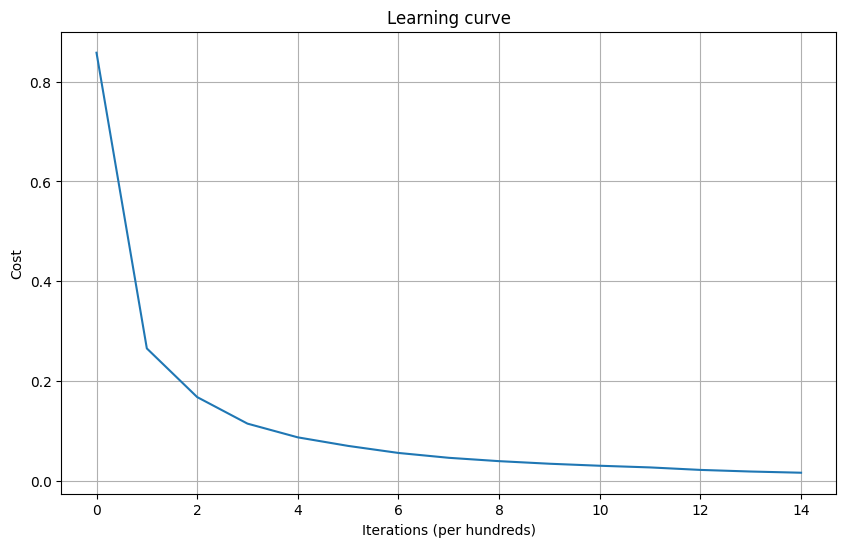


=== Training Set Performance ===
Training Accuracy: 100.00%
Training AUC: 1.0000

=== Test Set Performance ===
Test Accuracy: 85.71%
Test AUC: 0.9583

=== Detailed Classification Report ===
              precision    recall  f1-score   support

     Healthy       0.50      0.75      0.60         4
          OA       0.95      0.88      0.91        24

    accuracy                           0.86        28
   macro avg       0.73      0.81      0.76        28
weighted avg       0.89      0.86      0.87        28



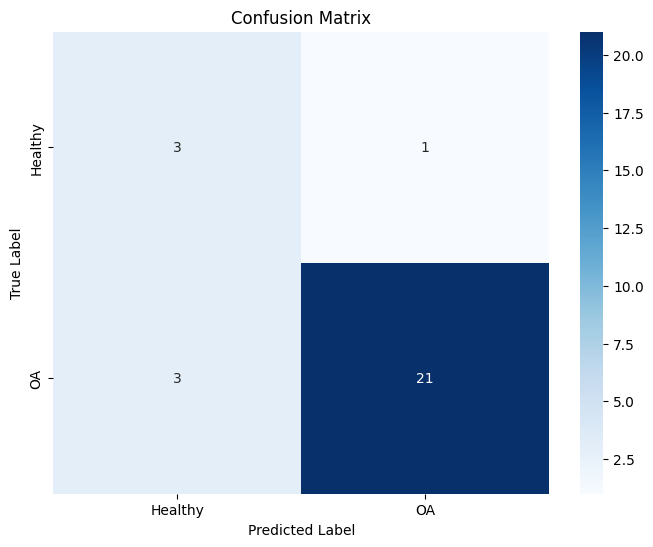

Test Accuracy: 100.00%, AUC: 1.0000

Testing: LR=0.005, L2=0.01, Architecture=[202, 128, 64, 1]
=== Gait Waveform Classification with Deep Neural Network ===

Preprocessing data...
Training set: 110 examples
Test set: 28 examples
Features: 202

Network architecture: [202, 128, 64, 1]
Learning rate: 0.005
Iterations: 1500
L2 regularization parameter: 0.01

Training model...
Cost after iteration 0: 0.689345
Cost after iteration 100: 0.264031
Cost after iteration 200: 0.207558
Cost after iteration 300: 0.178034
Cost after iteration 400: 0.157934
Cost after iteration 500: 0.142714
Cost after iteration 600: 0.130782
Cost after iteration 700: 0.120564
Cost after iteration 800: 0.111703
Cost after iteration 900: 0.103807
Cost after iteration 1000: 0.096976
Cost after iteration 1100: 0.090951
Cost after iteration 1200: 0.085598
Cost after iteration 1300: 0.080768
Cost after iteration 1400: 0.076449


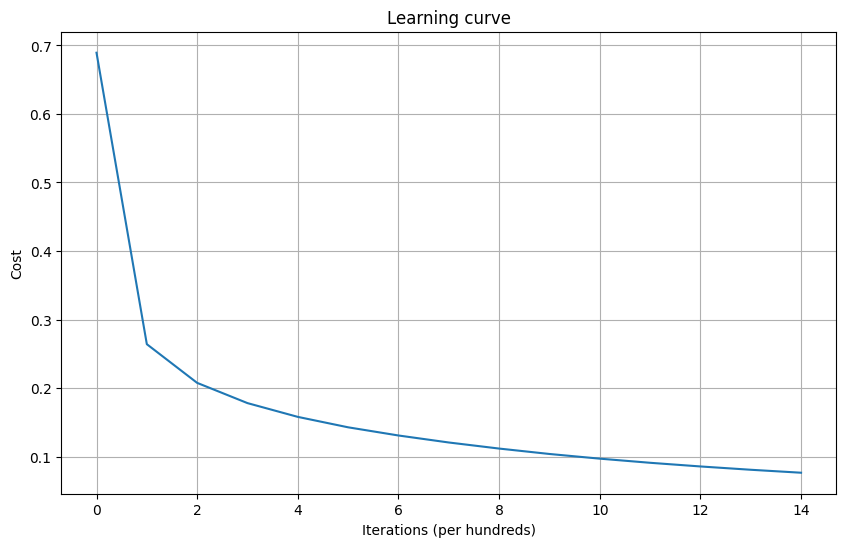


=== Training Set Performance ===
Training Accuracy: 99.09%
Training AUC: 0.9994

=== Test Set Performance ===
Test Accuracy: 89.29%
Test AUC: 0.9167

=== Detailed Classification Report ===
              precision    recall  f1-score   support

     Healthy       0.57      1.00      0.73         4
          OA       1.00      0.88      0.93        24

    accuracy                           0.89        28
   macro avg       0.79      0.94      0.83        28
weighted avg       0.94      0.89      0.90        28



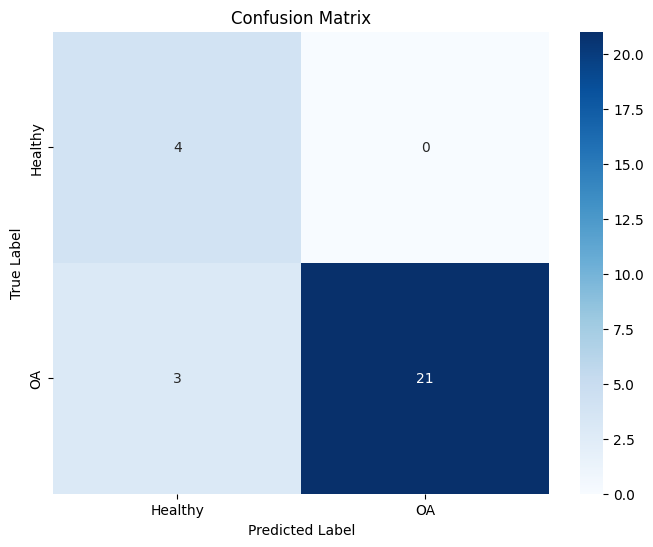

Test Accuracy: 99.09%, AUC: 0.9994

Testing: LR=0.005, L2=0.01, Architecture=[202, 128, 64, 32, 1]
=== Gait Waveform Classification with Deep Neural Network ===

Preprocessing data...
Training set: 110 examples
Test set: 28 examples
Features: 202

Network architecture: [202, 128, 64, 32, 1]
Learning rate: 0.005
Iterations: 1500
L2 regularization parameter: 0.01

Training model...
Cost after iteration 0: 0.784146
Cost after iteration 100: 0.279130
Cost after iteration 200: 0.206888
Cost after iteration 300: 0.170580
Cost after iteration 400: 0.146688
Cost after iteration 500: 0.128858
Cost after iteration 600: 0.114832
Cost after iteration 700: 0.103317
Cost after iteration 800: 0.093752
Cost after iteration 900: 0.086089
Cost after iteration 1000: 0.079649
Cost after iteration 1100: 0.074242
Cost after iteration 1200: 0.069350
Cost after iteration 1300: 0.064912
Cost after iteration 1400: 0.061072


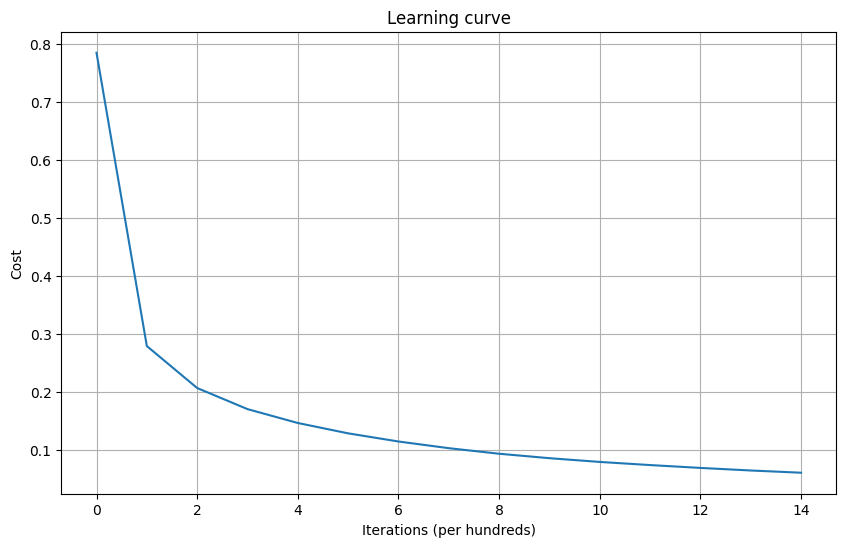


=== Training Set Performance ===
Training Accuracy: 99.09%
Training AUC: 0.9994

=== Test Set Performance ===
Test Accuracy: 89.29%
Test AUC: 0.9479

=== Detailed Classification Report ===
              precision    recall  f1-score   support

     Healthy       0.57      1.00      0.73         4
          OA       1.00      0.88      0.93        24

    accuracy                           0.89        28
   macro avg       0.79      0.94      0.83        28
weighted avg       0.94      0.89      0.90        28



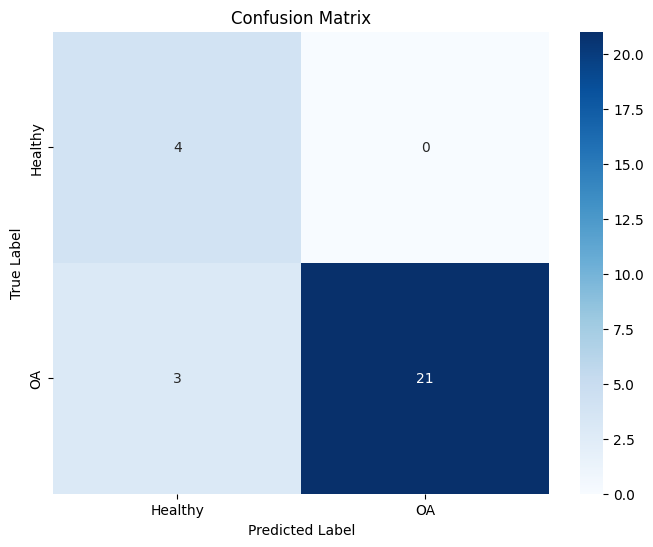

Test Accuracy: 99.09%, AUC: 0.9994

Testing: LR=0.005, L2=0.01, Architecture=[202, 128, 64, 32, 16, 1]
=== Gait Waveform Classification with Deep Neural Network ===

Preprocessing data...
Training set: 110 examples
Test set: 28 examples
Features: 202

Network architecture: [202, 128, 64, 32, 16, 1]
Learning rate: 0.005
Iterations: 1500
L2 regularization parameter: 0.01

Training model...
Cost after iteration 0: 0.880179
Cost after iteration 100: 0.287156
Cost after iteration 200: 0.189583
Cost after iteration 300: 0.136388
Cost after iteration 400: 0.108881
Cost after iteration 500: 0.091732
Cost after iteration 600: 0.077622
Cost after iteration 700: 0.067900
Cost after iteration 800: 0.061202
Cost after iteration 900: 0.056038
Cost after iteration 1000: 0.051999
Cost after iteration 1100: 0.048627
Cost after iteration 1200: 0.043665
Cost after iteration 1300: 0.040439
Cost after iteration 1400: 0.038050


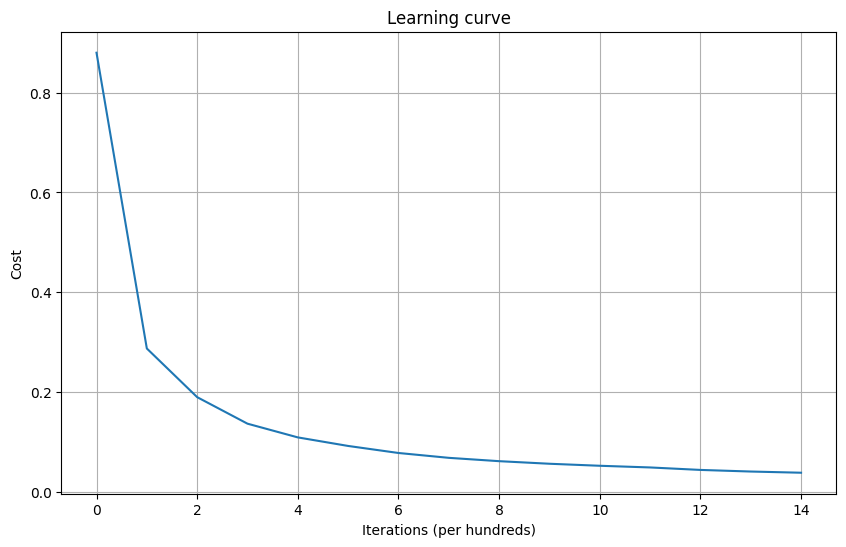


=== Training Set Performance ===
Training Accuracy: 100.00%
Training AUC: 1.0000

=== Test Set Performance ===
Test Accuracy: 85.71%
Test AUC: 0.9583

=== Detailed Classification Report ===
              precision    recall  f1-score   support

     Healthy       0.50      0.75      0.60         4
          OA       0.95      0.88      0.91        24

    accuracy                           0.86        28
   macro avg       0.73      0.81      0.76        28
weighted avg       0.89      0.86      0.87        28



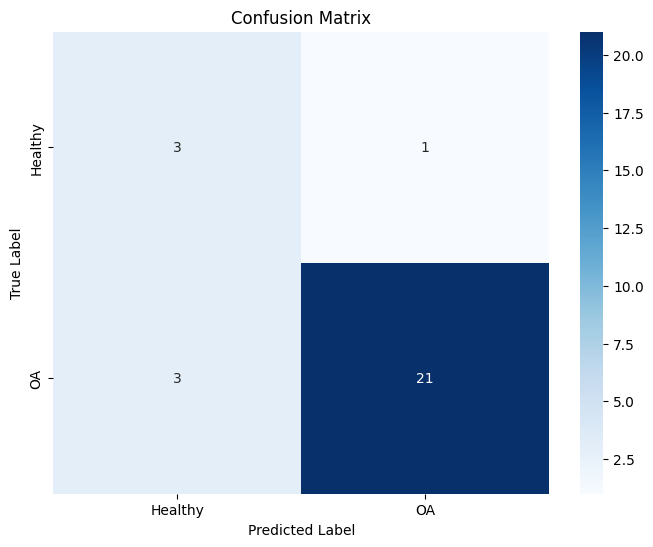

Test Accuracy: 100.00%, AUC: 1.0000

Testing: LR=0.005, L2=0.05, Architecture=[202, 128, 64, 1]
=== Gait Waveform Classification with Deep Neural Network ===

Preprocessing data...
Training set: 110 examples
Test set: 28 examples
Features: 202

Network architecture: [202, 128, 64, 1]
Learning rate: 0.005
Iterations: 1500
L2 regularization parameter: 0.05

Training model...
Cost after iteration 0: 0.759988
Cost after iteration 100: 0.334761
Cost after iteration 200: 0.278359
Cost after iteration 300: 0.248890
Cost after iteration 400: 0.228829
Cost after iteration 500: 0.213649
Cost after iteration 600: 0.201751
Cost after iteration 700: 0.191558
Cost after iteration 800: 0.182732
Cost after iteration 900: 0.174859
Cost after iteration 1000: 0.168053
Cost after iteration 1100: 0.162046
Cost after iteration 1200: 0.156698
Cost after iteration 1300: 0.151883
Cost after iteration 1400: 0.147580


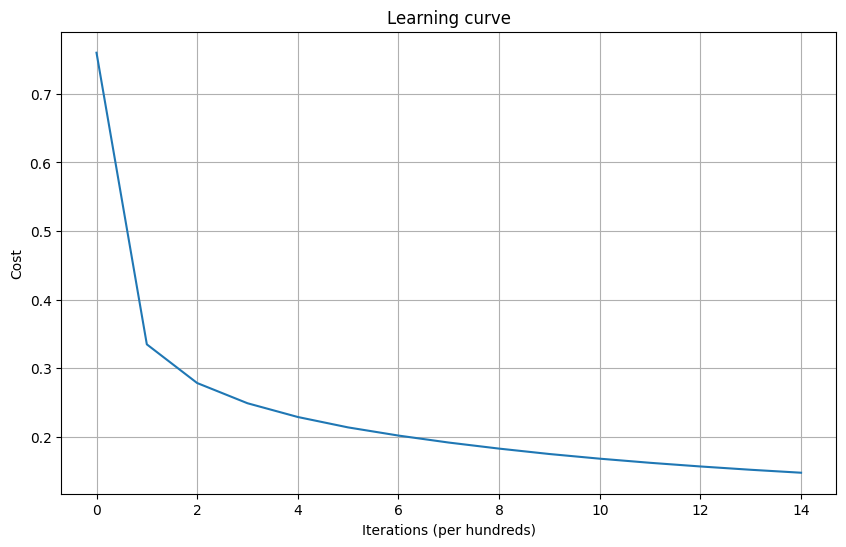


=== Training Set Performance ===
Training Accuracy: 99.09%
Training AUC: 0.9994

=== Test Set Performance ===
Test Accuracy: 89.29%
Test AUC: 0.9167

=== Detailed Classification Report ===
              precision    recall  f1-score   support

     Healthy       0.57      1.00      0.73         4
          OA       1.00      0.88      0.93        24

    accuracy                           0.89        28
   macro avg       0.79      0.94      0.83        28
weighted avg       0.94      0.89      0.90        28



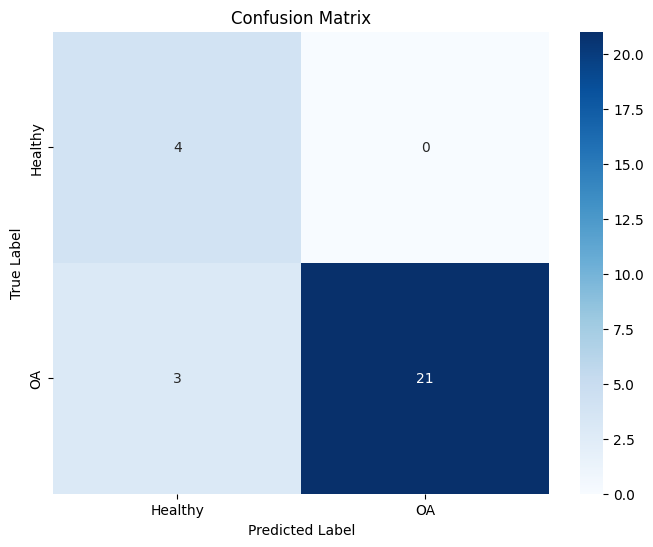

Test Accuracy: 99.09%, AUC: 0.9994

Testing: LR=0.005, L2=0.05, Architecture=[202, 128, 64, 32, 1]
=== Gait Waveform Classification with Deep Neural Network ===

Preprocessing data...
Training set: 110 examples
Test set: 28 examples
Features: 202

Network architecture: [202, 128, 64, 32, 1]
Learning rate: 0.005
Iterations: 1500
L2 regularization parameter: 0.05

Training model...
Cost after iteration 0: 0.866536
Cost after iteration 100: 0.361638
Cost after iteration 200: 0.289490
Cost after iteration 300: 0.253256
Cost after iteration 400: 0.229421
Cost after iteration 500: 0.211610
Cost after iteration 600: 0.197630
Cost after iteration 700: 0.186155
Cost after iteration 800: 0.176609
Cost after iteration 900: 0.168958
Cost after iteration 1000: 0.162535
Cost after iteration 1100: 0.157149
Cost after iteration 1200: 0.152306
Cost after iteration 1300: 0.147863
Cost after iteration 1400: 0.144024


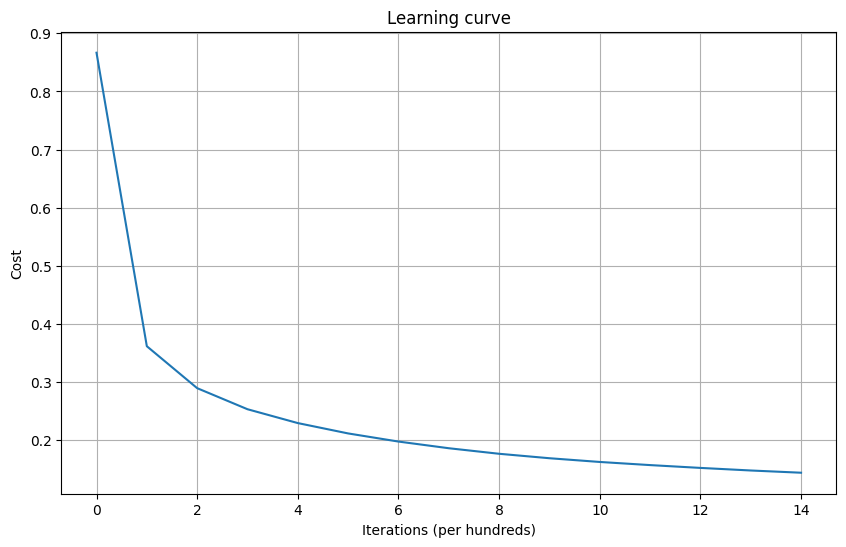


=== Training Set Performance ===
Training Accuracy: 99.09%
Training AUC: 0.9994

=== Test Set Performance ===
Test Accuracy: 89.29%
Test AUC: 0.9479

=== Detailed Classification Report ===
              precision    recall  f1-score   support

     Healthy       0.57      1.00      0.73         4
          OA       1.00      0.88      0.93        24

    accuracy                           0.89        28
   macro avg       0.79      0.94      0.83        28
weighted avg       0.94      0.89      0.90        28



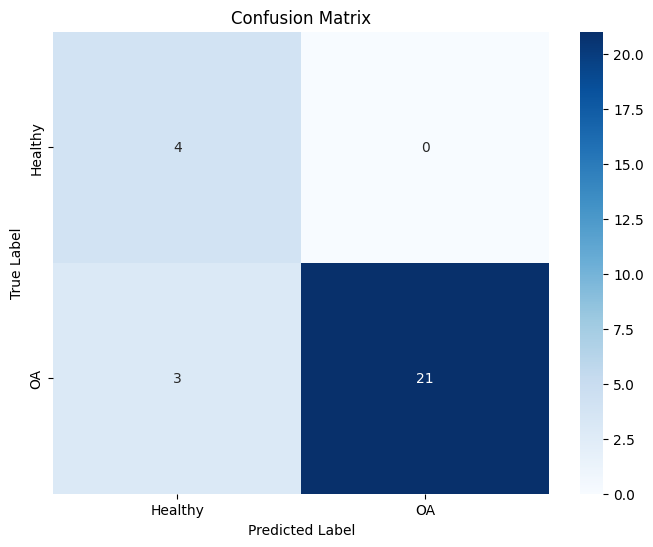

Test Accuracy: 99.09%, AUC: 0.9994

Testing: LR=0.005, L2=0.05, Architecture=[202, 128, 64, 32, 16, 1]
=== Gait Waveform Classification with Deep Neural Network ===

Preprocessing data...
Training set: 110 examples
Test set: 28 examples
Features: 202

Network architecture: [202, 128, 64, 32, 16, 1]
Learning rate: 0.005
Iterations: 1500
L2 regularization parameter: 0.05

Training model...
Cost after iteration 0: 0.968503
Cost after iteration 100: 0.375636
Cost after iteration 200: 0.278211
Cost after iteration 300: 0.225087
Cost after iteration 400: 0.197642
Cost after iteration 500: 0.180568
Cost after iteration 600: 0.166421
Cost after iteration 700: 0.156687
Cost after iteration 800: 0.150008
Cost after iteration 900: 0.144850
Cost after iteration 1000: 0.140830
Cost after iteration 1100: 0.137330
Cost after iteration 1200: 0.132438
Cost after iteration 1300: 0.129215
Cost after iteration 1400: 0.126820


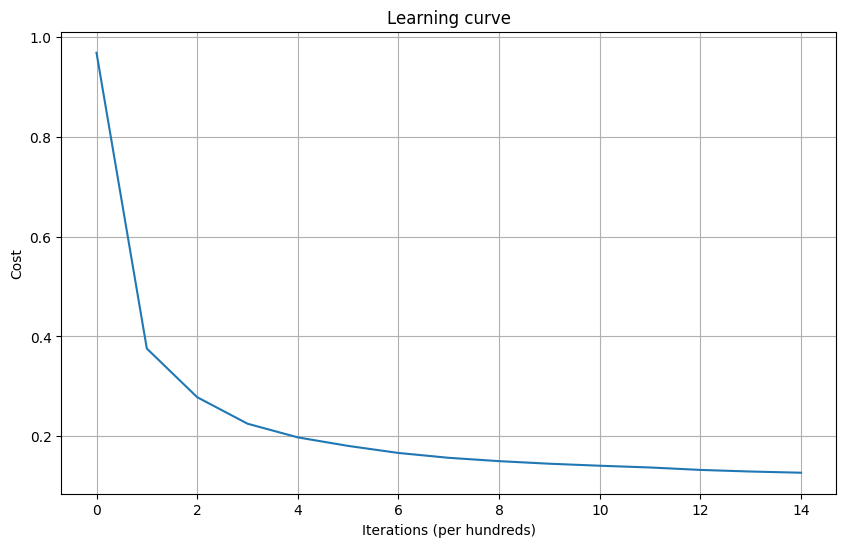


=== Training Set Performance ===
Training Accuracy: 100.00%
Training AUC: 1.0000

=== Test Set Performance ===
Test Accuracy: 85.71%
Test AUC: 0.9583

=== Detailed Classification Report ===
              precision    recall  f1-score   support

     Healthy       0.50      0.75      0.60         4
          OA       0.95      0.88      0.91        24

    accuracy                           0.86        28
   macro avg       0.73      0.81      0.76        28
weighted avg       0.89      0.86      0.87        28



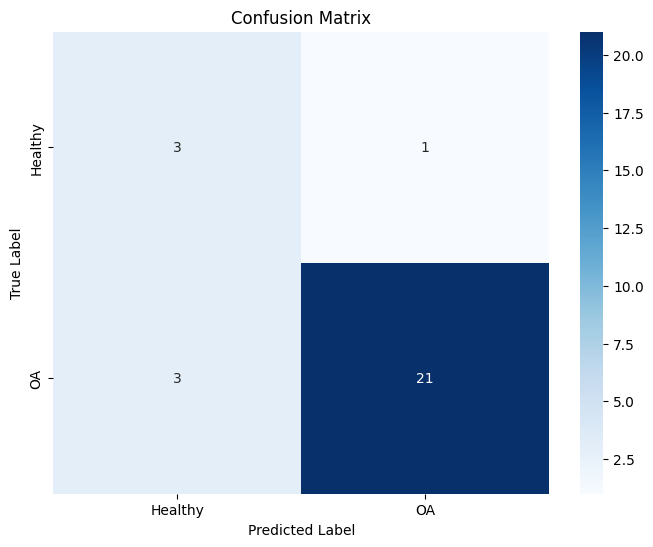

Test Accuracy: 100.00%, AUC: 1.0000

Testing: LR=0.01, L2=0.0, Architecture=[202, 128, 64, 1]
=== Gait Waveform Classification with Deep Neural Network ===

Preprocessing data...
Training set: 110 examples
Test set: 28 examples
Features: 202

Network architecture: [202, 128, 64, 1]
Learning rate: 0.01
Iterations: 1500
L2 regularization parameter: 0.0

Training model...
Cost after iteration 0: 0.671684
Cost after iteration 100: 0.189711
Cost after iteration 200: 0.140150
Cost after iteration 300: 0.112992
Cost after iteration 400: 0.093891
Cost after iteration 500: 0.079136
Cost after iteration 600: 0.067723
Cost after iteration 700: 0.058558
Cost after iteration 800: 0.051109
Cost after iteration 900: 0.044815
Cost after iteration 1000: 0.039468
Cost after iteration 1100: 0.034879
Cost after iteration 1200: 0.030953
Cost after iteration 1300: 0.027606
Cost after iteration 1400: 0.024778


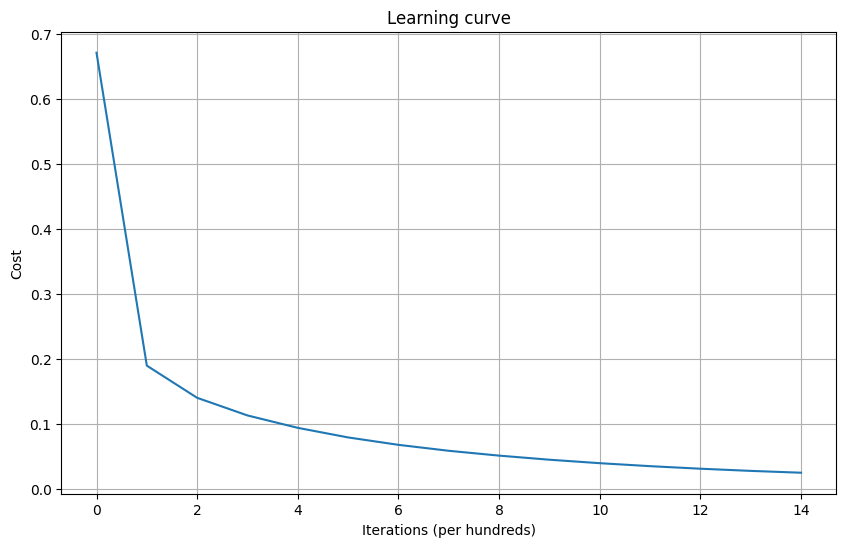


=== Training Set Performance ===
Training Accuracy: 100.00%
Training AUC: 1.0000

=== Test Set Performance ===
Test Accuracy: 89.29%
Test AUC: 0.8958

=== Detailed Classification Report ===
              precision    recall  f1-score   support

     Healthy       0.57      1.00      0.73         4
          OA       1.00      0.88      0.93        24

    accuracy                           0.89        28
   macro avg       0.79      0.94      0.83        28
weighted avg       0.94      0.89      0.90        28



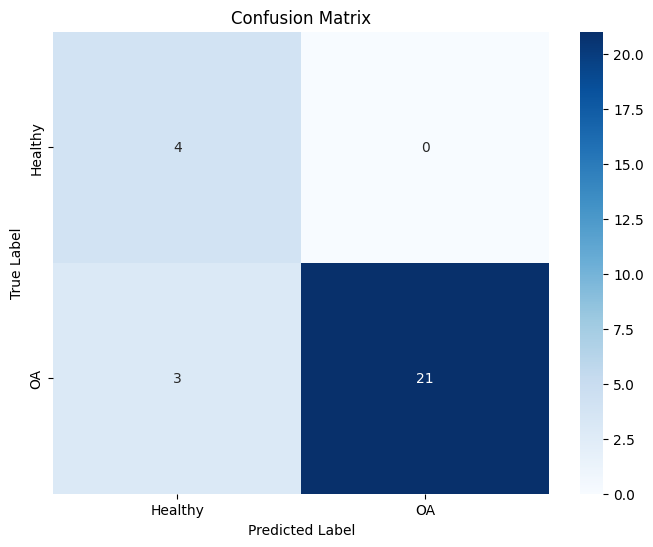

Test Accuracy: 100.00%, AUC: 1.0000

Testing: LR=0.01, L2=0.0, Architecture=[202, 128, 64, 32, 1]
=== Gait Waveform Classification with Deep Neural Network ===

Preprocessing data...
Training set: 110 examples
Test set: 28 examples
Features: 202

Network architecture: [202, 128, 64, 32, 1]
Learning rate: 0.01
Iterations: 1500
L2 regularization parameter: 0.0

Training model...
Cost after iteration 0: 0.763549
Cost after iteration 100: 0.186074
Cost after iteration 200: 0.125916
Cost after iteration 300: 0.094051
Cost after iteration 400: 0.072960
Cost after iteration 500: 0.058849
Cost after iteration 600: 0.048594
Cost after iteration 700: 0.040406
Cost after iteration 800: 0.034145
Cost after iteration 900: 0.029256
Cost after iteration 1000: 0.025264
Cost after iteration 1100: 0.021981
Cost after iteration 1200: 0.018712
Cost after iteration 1300: 0.015477
Cost after iteration 1400: 0.013171


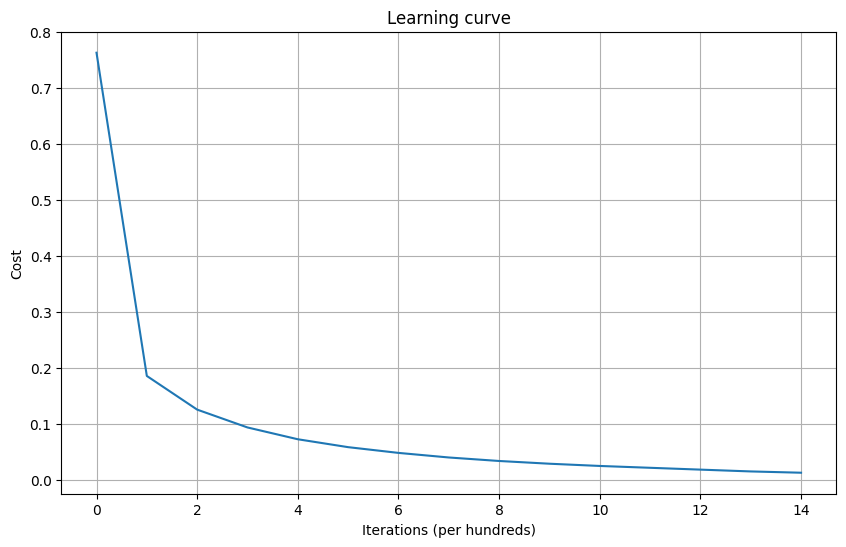


=== Training Set Performance ===
Training Accuracy: 100.00%
Training AUC: 1.0000

=== Test Set Performance ===
Test Accuracy: 89.29%
Test AUC: 0.9479

=== Detailed Classification Report ===
              precision    recall  f1-score   support

     Healthy       0.57      1.00      0.73         4
          OA       1.00      0.88      0.93        24

    accuracy                           0.89        28
   macro avg       0.79      0.94      0.83        28
weighted avg       0.94      0.89      0.90        28



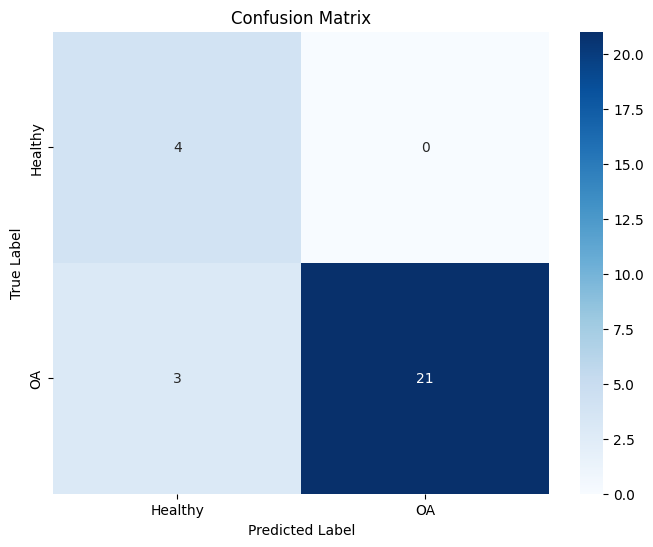

Test Accuracy: 100.00%, AUC: 1.0000

Testing: LR=0.01, L2=0.0, Architecture=[202, 128, 64, 32, 16, 1]
=== Gait Waveform Classification with Deep Neural Network ===

Preprocessing data...
Training set: 110 examples
Test set: 28 examples
Features: 202

Network architecture: [202, 128, 64, 32, 16, 1]
Learning rate: 0.01
Iterations: 1500
L2 regularization parameter: 0.0

Training model...
Cost after iteration 0: 0.858098
Cost after iteration 100: 0.167958
Cost after iteration 200: 0.086785
Cost after iteration 300: 0.055437
Cost after iteration 400: 0.038871
Cost after iteration 500: 0.029656
Cost after iteration 600: 0.021296
Cost after iteration 700: 0.015711
Cost after iteration 800: 0.012411
Cost after iteration 900: 0.010054
Cost after iteration 1000: 0.008355
Cost after iteration 1100: 0.007102
Cost after iteration 1200: 0.006129
Cost after iteration 1300: 0.005361
Cost after iteration 1400: 0.004745


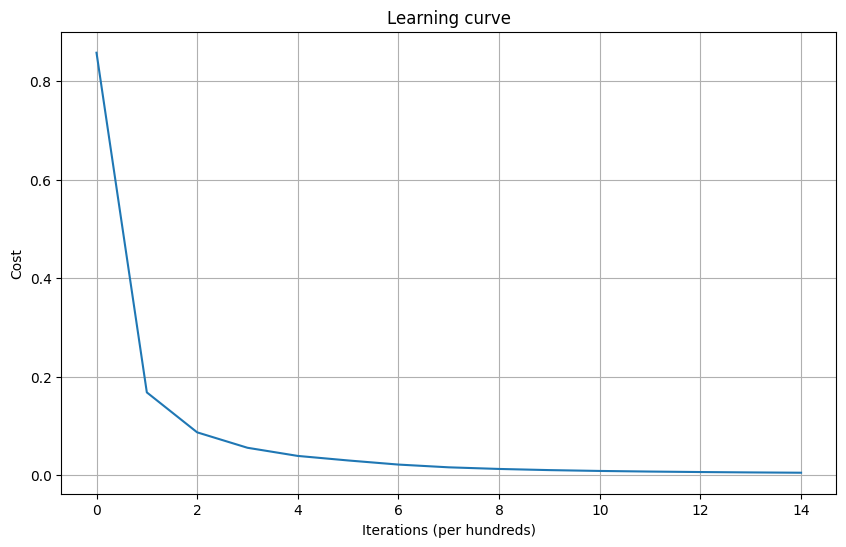


=== Training Set Performance ===
Training Accuracy: 100.00%
Training AUC: 1.0000

=== Test Set Performance ===
Test Accuracy: 89.29%
Test AUC: 0.9792

=== Detailed Classification Report ===
              precision    recall  f1-score   support

     Healthy       0.57      1.00      0.73         4
          OA       1.00      0.88      0.93        24

    accuracy                           0.89        28
   macro avg       0.79      0.94      0.83        28
weighted avg       0.94      0.89      0.90        28



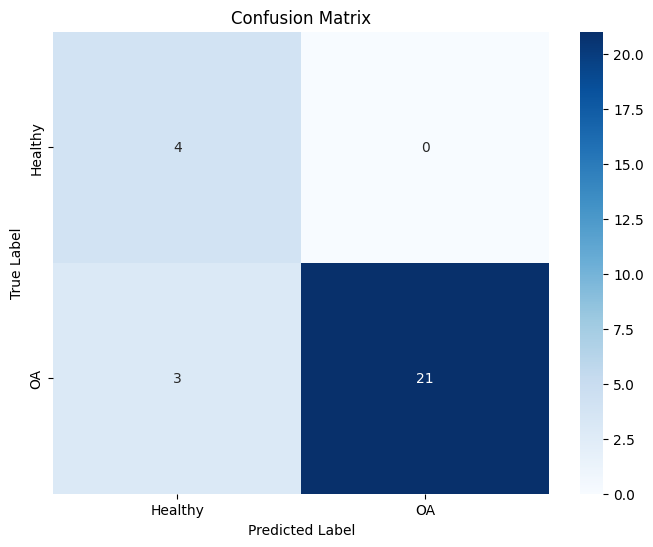

Test Accuracy: 100.00%, AUC: 1.0000

Testing: LR=0.01, L2=0.01, Architecture=[202, 128, 64, 1]
=== Gait Waveform Classification with Deep Neural Network ===

Preprocessing data...
Training set: 110 examples
Test set: 28 examples
Features: 202

Network architecture: [202, 128, 64, 1]
Learning rate: 0.01
Iterations: 1500
L2 regularization parameter: 0.01

Training model...
Cost after iteration 0: 0.689345
Cost after iteration 100: 0.207428
Cost after iteration 200: 0.157906
Cost after iteration 300: 0.130779
Cost after iteration 400: 0.111708
Cost after iteration 500: 0.096984
Cost after iteration 600: 0.085594
Cost after iteration 700: 0.076452
Cost after iteration 800: 0.069027
Cost after iteration 900: 0.062749
Cost after iteration 1000: 0.057406
Cost after iteration 1100: 0.052835
Cost after iteration 1200: 0.048921
Cost after iteration 1300: 0.045588
Cost after iteration 1400: 0.042772


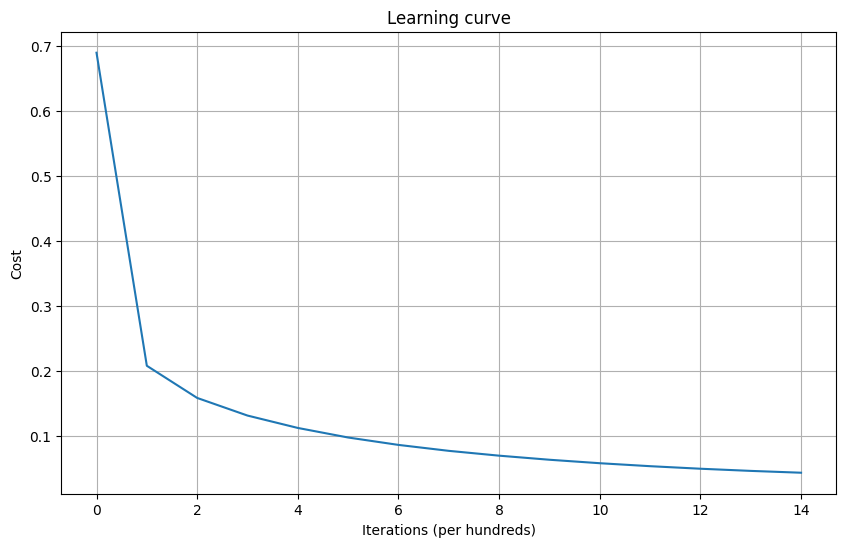


=== Training Set Performance ===
Training Accuracy: 100.00%
Training AUC: 1.0000

=== Test Set Performance ===
Test Accuracy: 89.29%
Test AUC: 0.8958

=== Detailed Classification Report ===
              precision    recall  f1-score   support

     Healthy       0.57      1.00      0.73         4
          OA       1.00      0.88      0.93        24

    accuracy                           0.89        28
   macro avg       0.79      0.94      0.83        28
weighted avg       0.94      0.89      0.90        28



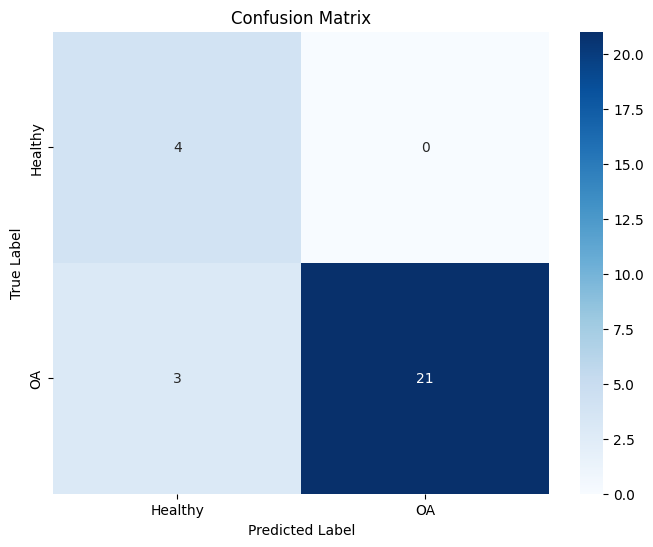

Test Accuracy: 100.00%, AUC: 1.0000

Testing: LR=0.01, L2=0.01, Architecture=[202, 128, 64, 32, 1]
=== Gait Waveform Classification with Deep Neural Network ===

Preprocessing data...
Training set: 110 examples
Test set: 28 examples
Features: 202

Network architecture: [202, 128, 64, 32, 1]
Learning rate: 0.01
Iterations: 1500
L2 regularization parameter: 0.01

Training model...
Cost after iteration 0: 0.784146
Cost after iteration 100: 0.206773
Cost after iteration 200: 0.146668
Cost after iteration 300: 0.114865
Cost after iteration 400: 0.093792
Cost after iteration 500: 0.079705
Cost after iteration 600: 0.069519
Cost after iteration 700: 0.061393
Cost after iteration 800: 0.055114
Cost after iteration 900: 0.050236
Cost after iteration 1000: 0.046252
Cost after iteration 1100: 0.042961
Cost after iteration 1200: 0.039798
Cost after iteration 1300: 0.036483
Cost after iteration 1400: 0.034154


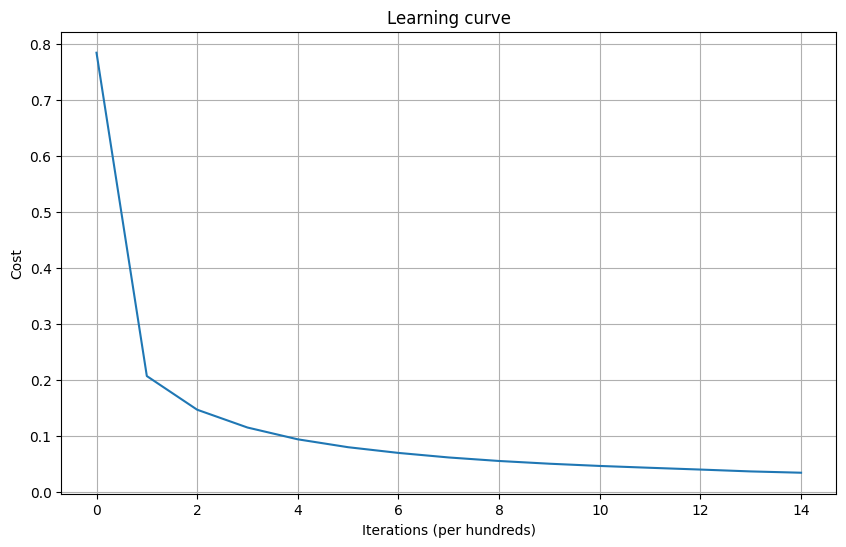


=== Training Set Performance ===
Training Accuracy: 100.00%
Training AUC: 1.0000

=== Test Set Performance ===
Test Accuracy: 89.29%
Test AUC: 0.9479

=== Detailed Classification Report ===
              precision    recall  f1-score   support

     Healthy       0.57      1.00      0.73         4
          OA       1.00      0.88      0.93        24

    accuracy                           0.89        28
   macro avg       0.79      0.94      0.83        28
weighted avg       0.94      0.89      0.90        28



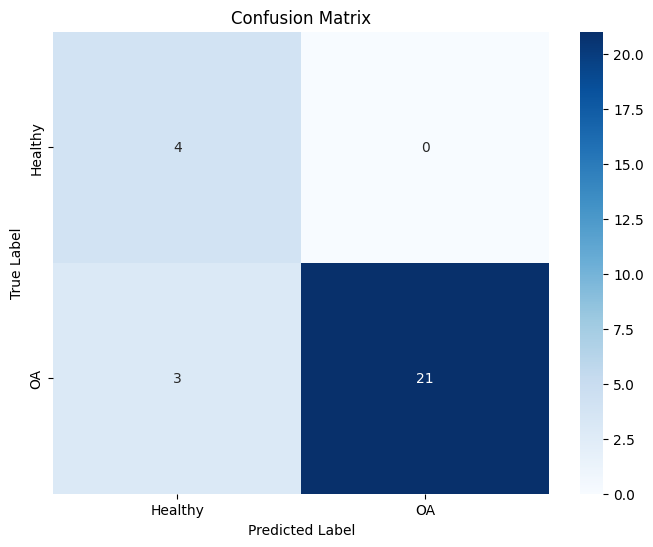

Test Accuracy: 100.00%, AUC: 1.0000

Testing: LR=0.01, L2=0.01, Architecture=[202, 128, 64, 32, 16, 1]
=== Gait Waveform Classification with Deep Neural Network ===

Preprocessing data...
Training set: 110 examples
Test set: 28 examples
Features: 202

Network architecture: [202, 128, 64, 32, 16, 1]
Learning rate: 0.01
Iterations: 1500
L2 regularization parameter: 0.01

Training model...
Cost after iteration 0: 0.880179
Cost after iteration 100: 0.189957
Cost after iteration 200: 0.109004
Cost after iteration 300: 0.077651
Cost after iteration 400: 0.061116
Cost after iteration 500: 0.051940
Cost after iteration 600: 0.043558
Cost after iteration 700: 0.038025
Cost after iteration 800: 0.034739
Cost after iteration 900: 0.032384
Cost after iteration 1000: 0.030698
Cost after iteration 1100: 0.029449
Cost after iteration 1200: 0.028481
Cost after iteration 1300: 0.027717
Cost after iteration 1400: 0.027104


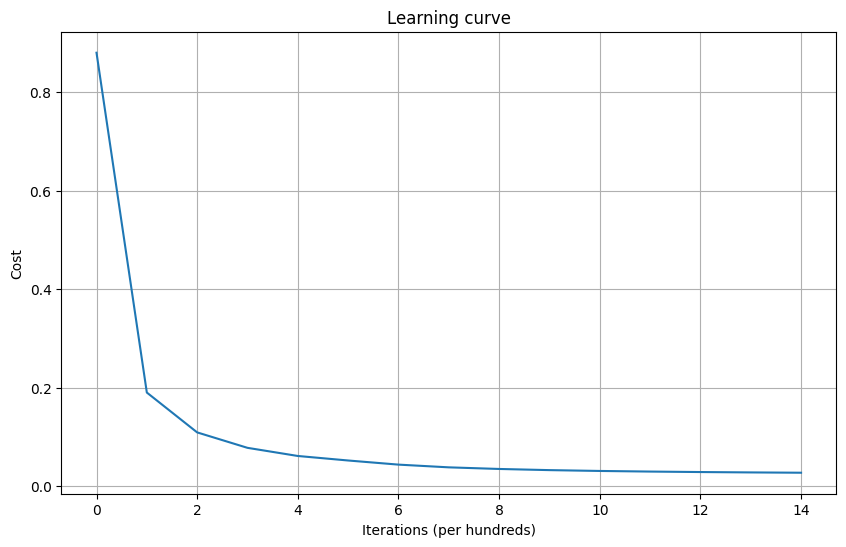


=== Training Set Performance ===
Training Accuracy: 100.00%
Training AUC: 1.0000

=== Test Set Performance ===
Test Accuracy: 89.29%
Test AUC: 0.9792

=== Detailed Classification Report ===
              precision    recall  f1-score   support

     Healthy       0.57      1.00      0.73         4
          OA       1.00      0.88      0.93        24

    accuracy                           0.89        28
   macro avg       0.79      0.94      0.83        28
weighted avg       0.94      0.89      0.90        28



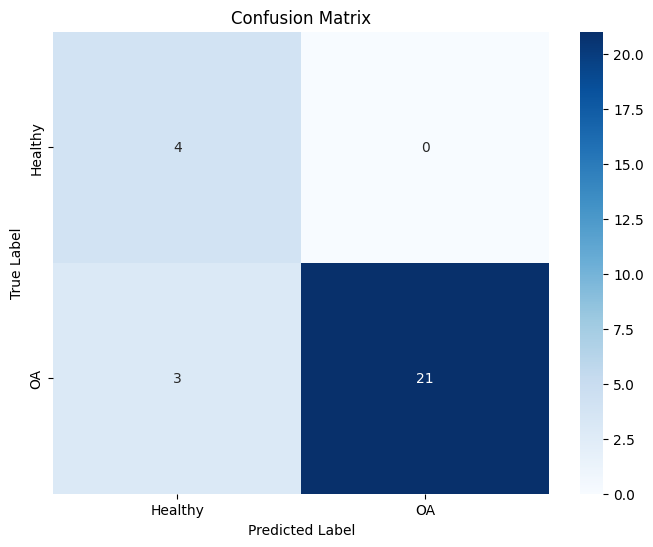

Test Accuracy: 100.00%, AUC: 1.0000

Testing: LR=0.01, L2=0.05, Architecture=[202, 128, 64, 1]
=== Gait Waveform Classification with Deep Neural Network ===

Preprocessing data...
Training set: 110 examples
Test set: 28 examples
Features: 202

Network architecture: [202, 128, 64, 1]
Learning rate: 0.01
Iterations: 1500
L2 regularization parameter: 0.05

Training model...
Cost after iteration 0: 0.759988
Cost after iteration 100: 0.278227
Cost after iteration 200: 0.228806
Cost after iteration 300: 0.201750
Cost after iteration 400: 0.182735
Cost after iteration 500: 0.168058
Cost after iteration 600: 0.156694
Cost after iteration 700: 0.147583
Cost after iteration 800: 0.140174
Cost after iteration 900: 0.133908
Cost after iteration 1000: 0.128558
Cost after iteration 1100: 0.123982
Cost after iteration 1200: 0.120048
Cost after iteration 1300: 0.116703
Cost after iteration 1400: 0.113870


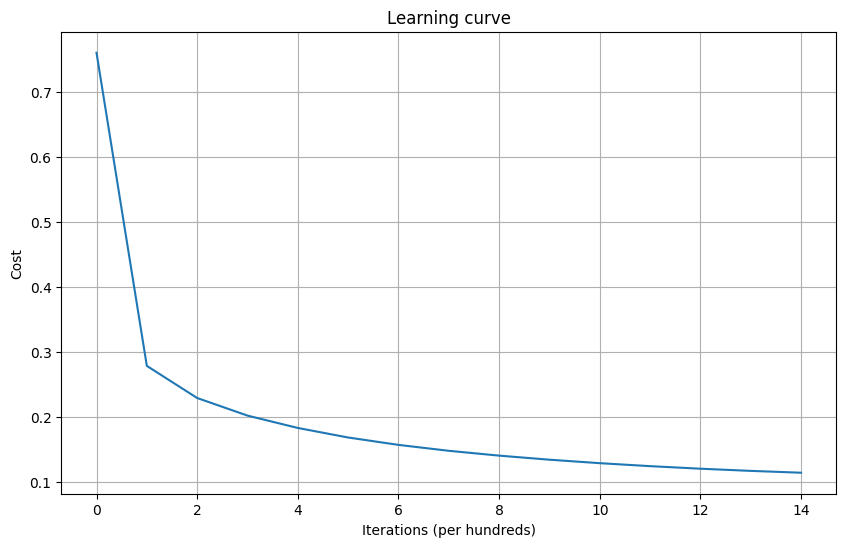


=== Training Set Performance ===
Training Accuracy: 100.00%
Training AUC: 1.0000

=== Test Set Performance ===
Test Accuracy: 89.29%
Test AUC: 0.8958

=== Detailed Classification Report ===
              precision    recall  f1-score   support

     Healthy       0.57      1.00      0.73         4
          OA       1.00      0.88      0.93        24

    accuracy                           0.89        28
   macro avg       0.79      0.94      0.83        28
weighted avg       0.94      0.89      0.90        28



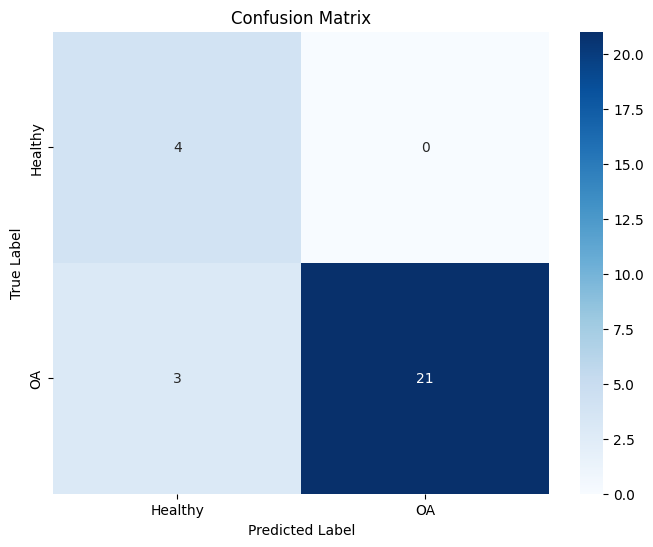

Test Accuracy: 100.00%, AUC: 1.0000

Testing: LR=0.01, L2=0.05, Architecture=[202, 128, 64, 32, 1]
=== Gait Waveform Classification with Deep Neural Network ===

Preprocessing data...
Training set: 110 examples
Test set: 28 examples
Features: 202

Network architecture: [202, 128, 64, 32, 1]
Learning rate: 0.01
Iterations: 1500
L2 regularization parameter: 0.05

Training model...
Cost after iteration 0: 0.866536
Cost after iteration 100: 0.289361
Cost after iteration 200: 0.229385
Cost after iteration 300: 0.197638
Cost after iteration 400: 0.176631
Cost after iteration 500: 0.162573
Cost after iteration 600: 0.152387
Cost after iteration 700: 0.144228
Cost after iteration 800: 0.137959
Cost after iteration 900: 0.133066
Cost after iteration 1000: 0.129061
Cost after iteration 1100: 0.125751
Cost after iteration 1200: 0.122545
Cost after iteration 1300: 0.119214
Cost after iteration 1400: 0.116843


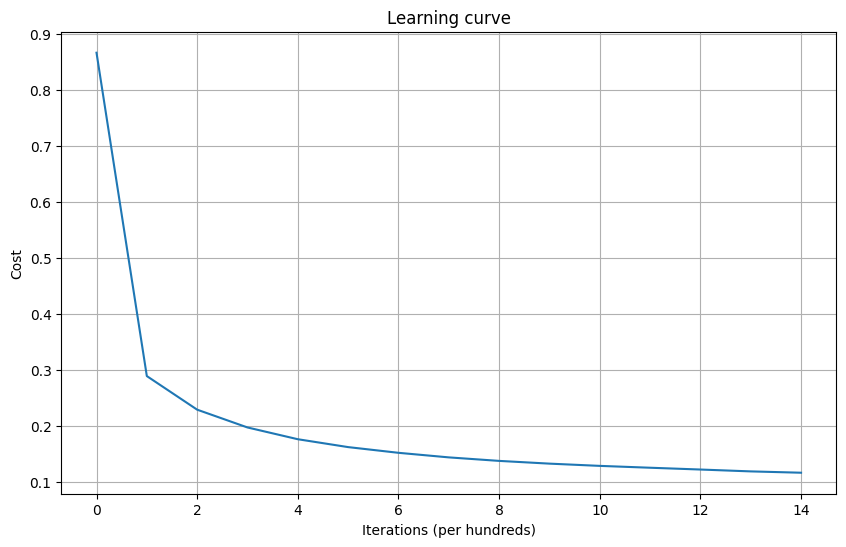


=== Training Set Performance ===
Training Accuracy: 100.00%
Training AUC: 1.0000

=== Test Set Performance ===
Test Accuracy: 89.29%
Test AUC: 0.9479

=== Detailed Classification Report ===
              precision    recall  f1-score   support

     Healthy       0.57      1.00      0.73         4
          OA       1.00      0.88      0.93        24

    accuracy                           0.89        28
   macro avg       0.79      0.94      0.83        28
weighted avg       0.94      0.89      0.90        28



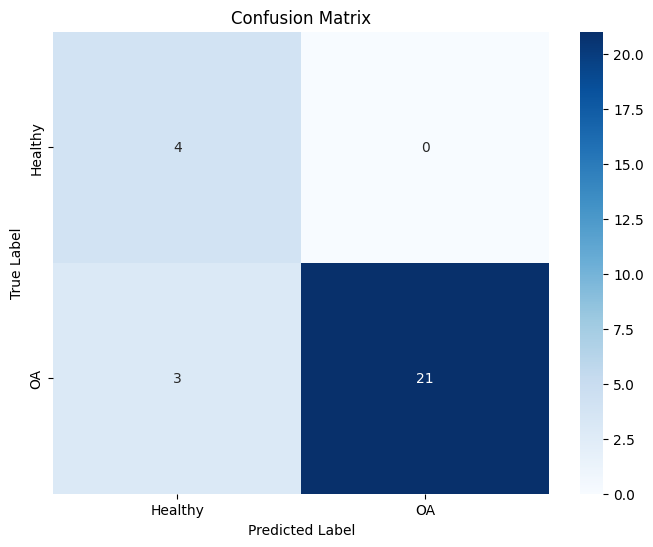

Test Accuracy: 100.00%, AUC: 1.0000

Testing: LR=0.01, L2=0.05, Architecture=[202, 128, 64, 32, 16, 1]
=== Gait Waveform Classification with Deep Neural Network ===

Preprocessing data...
Training set: 110 examples
Test set: 28 examples
Features: 202

Network architecture: [202, 128, 64, 32, 16, 1]
Learning rate: 0.01
Iterations: 1500
L2 regularization parameter: 0.05

Training model...
Cost after iteration 0: 0.968503
Cost after iteration 100: 0.278732
Cost after iteration 200: 0.197786
Cost after iteration 300: 0.166499
Cost after iteration 400: 0.149968
Cost after iteration 500: 0.140800
Cost after iteration 600: 0.132394
Cost after iteration 700: 0.126813
Cost after iteration 800: 0.123485
Cost after iteration 900: 0.121032
Cost after iteration 1000: 0.119303
Cost after iteration 1100: 0.117992
Cost after iteration 1200: 0.116963
Cost after iteration 1300: 0.116132
Cost after iteration 1400: 0.115451


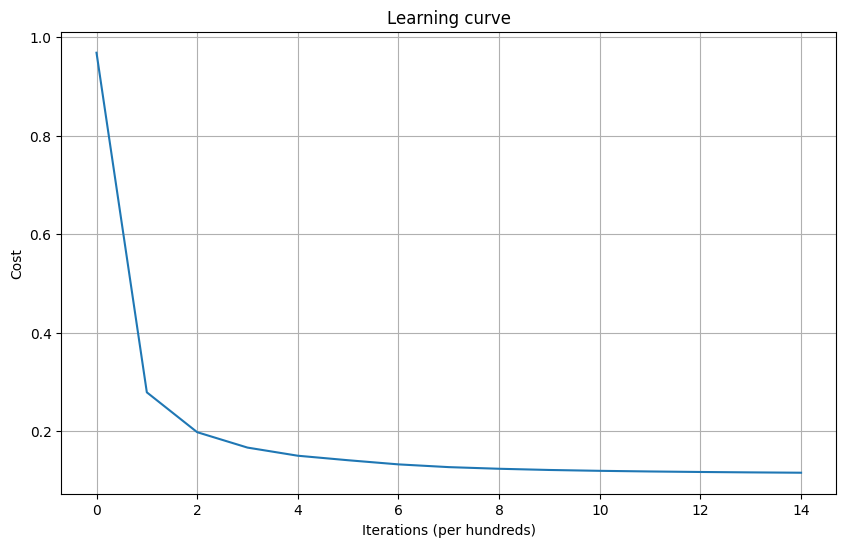


=== Training Set Performance ===
Training Accuracy: 100.00%
Training AUC: 1.0000

=== Test Set Performance ===
Test Accuracy: 89.29%
Test AUC: 0.9792

=== Detailed Classification Report ===
              precision    recall  f1-score   support

     Healthy       0.57      1.00      0.73         4
          OA       1.00      0.88      0.93        24

    accuracy                           0.89        28
   macro avg       0.79      0.94      0.83        28
weighted avg       0.94      0.89      0.90        28



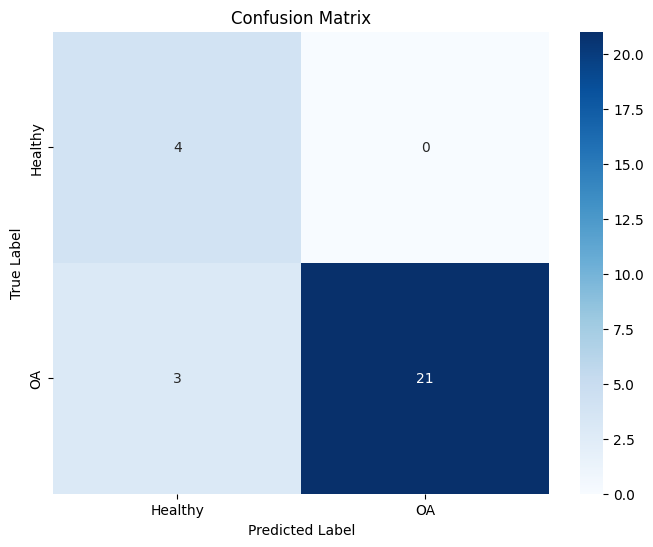

Test Accuracy: 100.00%, AUC: 1.0000

Testing: LR=0.02, L2=0.0, Architecture=[202, 128, 64, 1]
=== Gait Waveform Classification with Deep Neural Network ===

Preprocessing data...
Training set: 110 examples
Test set: 28 examples
Features: 202

Network architecture: [202, 128, 64, 1]
Learning rate: 0.02
Iterations: 1500
L2 regularization parameter: 0.0

Training model...
Cost after iteration 0: 0.671684
Cost after iteration 100: 0.140502
Cost after iteration 200: 0.094223
Cost after iteration 300: 0.067985
Cost after iteration 400: 0.051266
Cost after iteration 500: 0.039484
Cost after iteration 600: 0.030945
Cost after iteration 700: 0.024773
Cost after iteration 800: 0.020115
Cost after iteration 900: 0.016566
Cost after iteration 1000: 0.013917
Cost after iteration 1100: 0.011863
Cost after iteration 1200: 0.010230
Cost after iteration 1300: 0.008917
Cost after iteration 1400: 0.007856


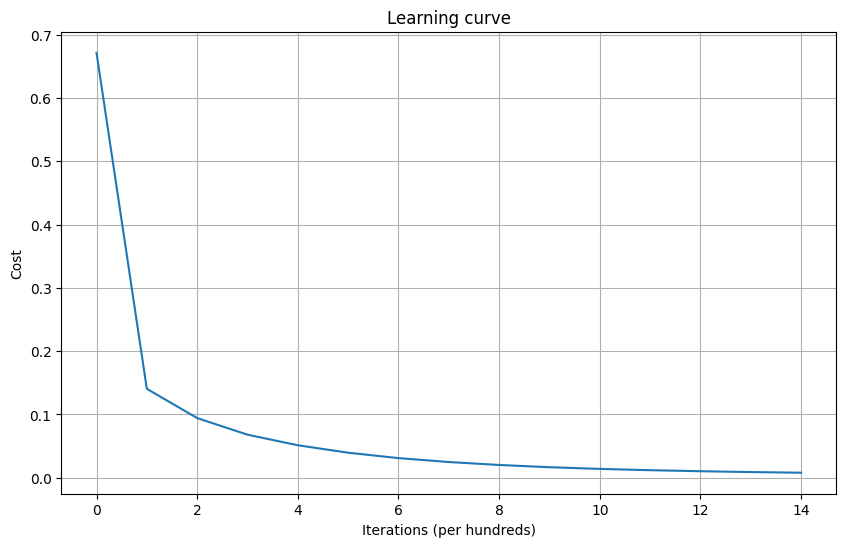


=== Training Set Performance ===
Training Accuracy: 100.00%
Training AUC: 1.0000

=== Test Set Performance ===
Test Accuracy: 89.29%
Test AUC: 0.9062

=== Detailed Classification Report ===
              precision    recall  f1-score   support

     Healthy       0.57      1.00      0.73         4
          OA       1.00      0.88      0.93        24

    accuracy                           0.89        28
   macro avg       0.79      0.94      0.83        28
weighted avg       0.94      0.89      0.90        28



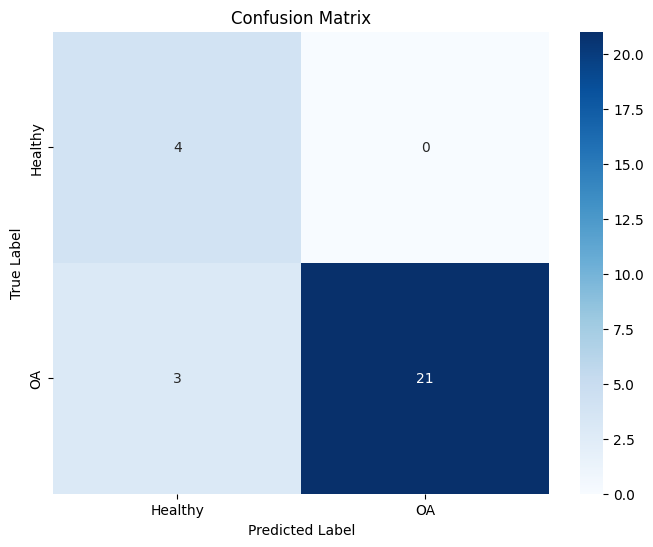

Test Accuracy: 100.00%, AUC: 1.0000

Testing: LR=0.02, L2=0.0, Architecture=[202, 128, 64, 32, 1]
=== Gait Waveform Classification with Deep Neural Network ===

Preprocessing data...
Training set: 110 examples
Test set: 28 examples
Features: 202

Network architecture: [202, 128, 64, 32, 1]
Learning rate: 0.02
Iterations: 1500
L2 regularization parameter: 0.0

Training model...
Cost after iteration 0: 0.763549
Cost after iteration 100: 0.127031
Cost after iteration 200: 0.073636
Cost after iteration 300: 0.049049
Cost after iteration 400: 0.034370
Cost after iteration 500: 0.025428
Cost after iteration 600: 0.018166
Cost after iteration 700: 0.012943
Cost after iteration 800: 0.009863
Cost after iteration 900: 0.007876
Cost after iteration 1000: 0.006472
Cost after iteration 1100: 0.005435
Cost after iteration 1200: 0.004647
Cost after iteration 1300: 0.003979
Cost after iteration 1400: 0.003464


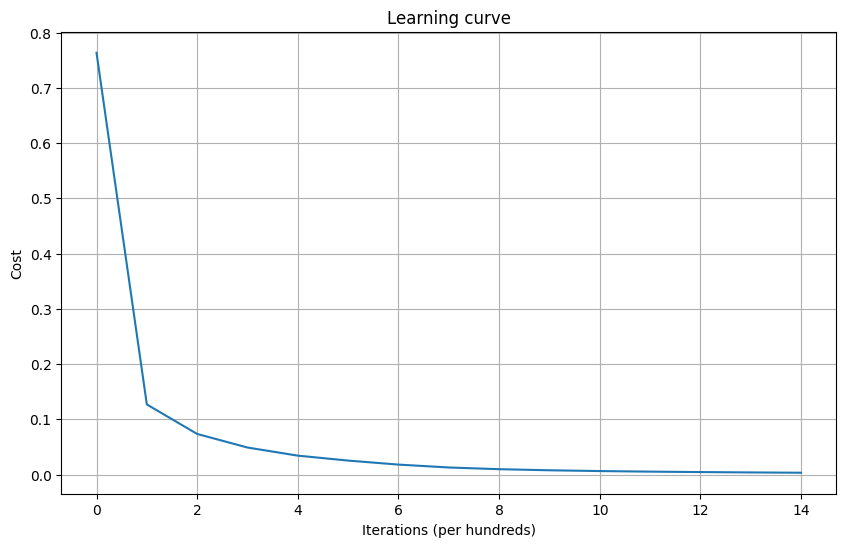


=== Training Set Performance ===
Training Accuracy: 100.00%
Training AUC: 1.0000

=== Test Set Performance ===
Test Accuracy: 89.29%
Test AUC: 0.9583

=== Detailed Classification Report ===
              precision    recall  f1-score   support

     Healthy       0.57      1.00      0.73         4
          OA       1.00      0.88      0.93        24

    accuracy                           0.89        28
   macro avg       0.79      0.94      0.83        28
weighted avg       0.94      0.89      0.90        28



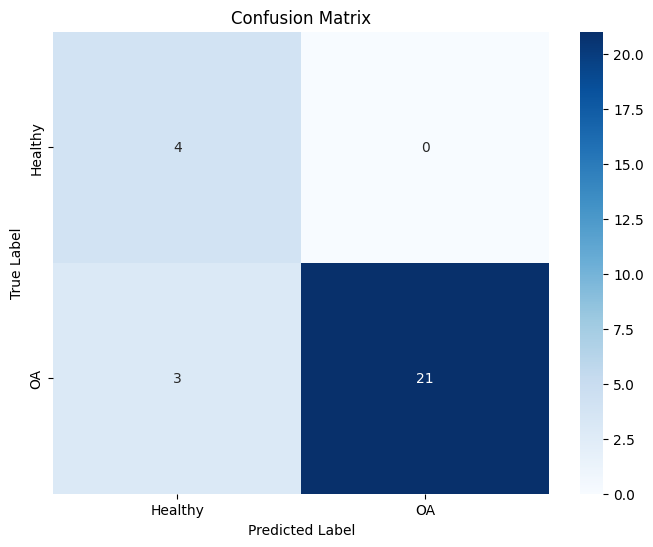

Test Accuracy: 100.00%, AUC: 1.0000

Testing: LR=0.02, L2=0.0, Architecture=[202, 128, 64, 32, 16, 1]
=== Gait Waveform Classification with Deep Neural Network ===

Preprocessing data...
Training set: 110 examples
Test set: 28 examples
Features: 202

Network architecture: [202, 128, 64, 32, 16, 1]
Learning rate: 0.02
Iterations: 1500
L2 regularization parameter: 0.0

Training model...
Cost after iteration 0: 0.858098
Cost after iteration 100: 0.086666
Cost after iteration 200: 0.039541
Cost after iteration 300: 0.024792
Cost after iteration 400: 0.015258
Cost after iteration 500: 0.009951
Cost after iteration 600: 0.007151
Cost after iteration 700: 0.005475
Cost after iteration 800: 0.004380
Cost after iteration 900: 0.003606
Cost after iteration 1000: 0.003046
Cost after iteration 1100: 0.002609
Cost after iteration 1200: 0.002266
Cost after iteration 1300: 0.001992
Cost after iteration 1400: 0.001768


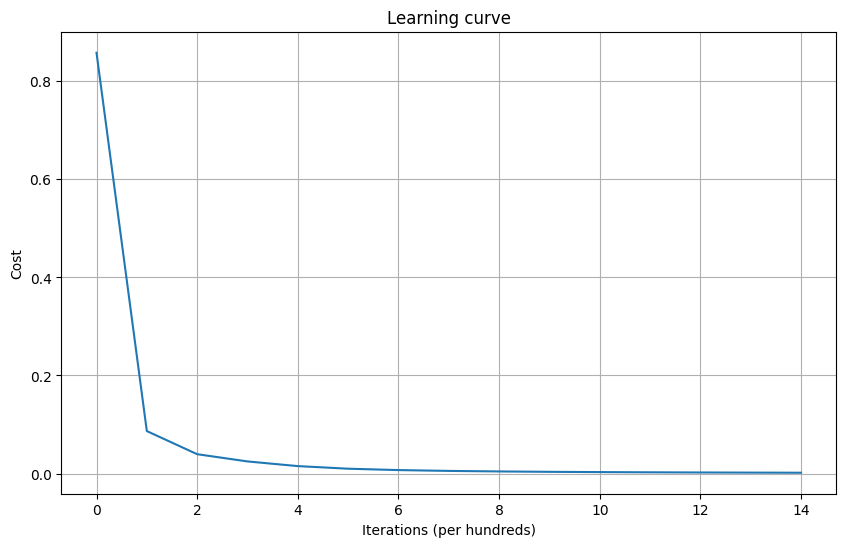


=== Training Set Performance ===
Training Accuracy: 100.00%
Training AUC: 1.0000

=== Test Set Performance ===
Test Accuracy: 89.29%
Test AUC: 0.9688

=== Detailed Classification Report ===
              precision    recall  f1-score   support

     Healthy       0.57      1.00      0.73         4
          OA       1.00      0.88      0.93        24

    accuracy                           0.89        28
   macro avg       0.79      0.94      0.83        28
weighted avg       0.94      0.89      0.90        28



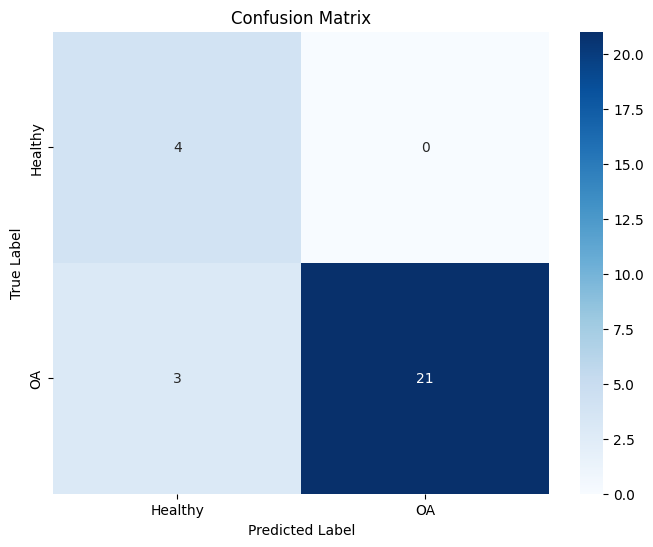

Test Accuracy: 100.00%, AUC: 1.0000

Testing: LR=0.02, L2=0.01, Architecture=[202, 128, 64, 1]
=== Gait Waveform Classification with Deep Neural Network ===

Preprocessing data...
Training set: 110 examples
Test set: 28 examples
Features: 202

Network architecture: [202, 128, 64, 1]
Learning rate: 0.02
Iterations: 1500
L2 regularization parameter: 0.01

Training model...
Cost after iteration 0: 0.689345
Cost after iteration 100: 0.158266
Cost after iteration 200: 0.112059
Cost after iteration 300: 0.085857
Cost after iteration 400: 0.069180
Cost after iteration 500: 0.057429
Cost after iteration 600: 0.048918
Cost after iteration 700: 0.042767
Cost after iteration 800: 0.038127
Cost after iteration 900: 0.034594
Cost after iteration 1000: 0.031956
Cost after iteration 1100: 0.029912
Cost after iteration 1200: 0.028285
Cost after iteration 1300: 0.026978
Cost after iteration 1400: 0.025924


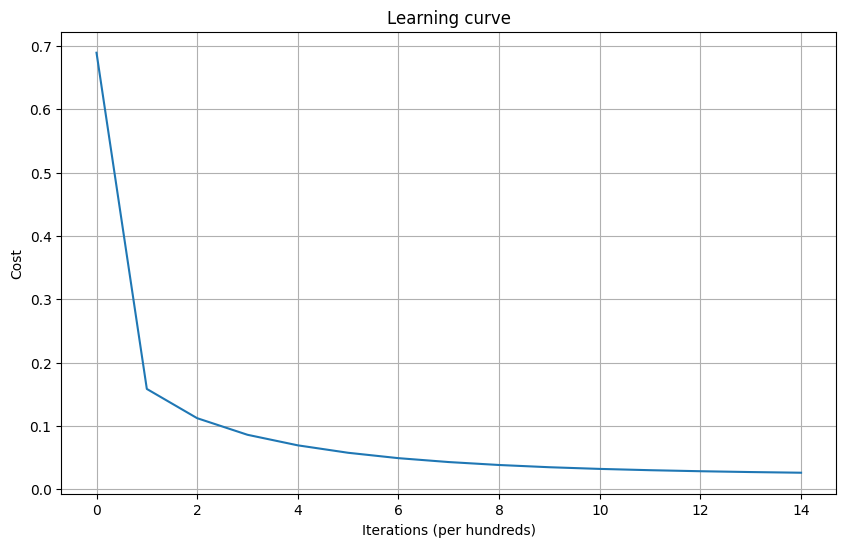


=== Training Set Performance ===
Training Accuracy: 100.00%
Training AUC: 1.0000

=== Test Set Performance ===
Test Accuracy: 89.29%
Test AUC: 0.9062

=== Detailed Classification Report ===
              precision    recall  f1-score   support

     Healthy       0.57      1.00      0.73         4
          OA       1.00      0.88      0.93        24

    accuracy                           0.89        28
   macro avg       0.79      0.94      0.83        28
weighted avg       0.94      0.89      0.90        28



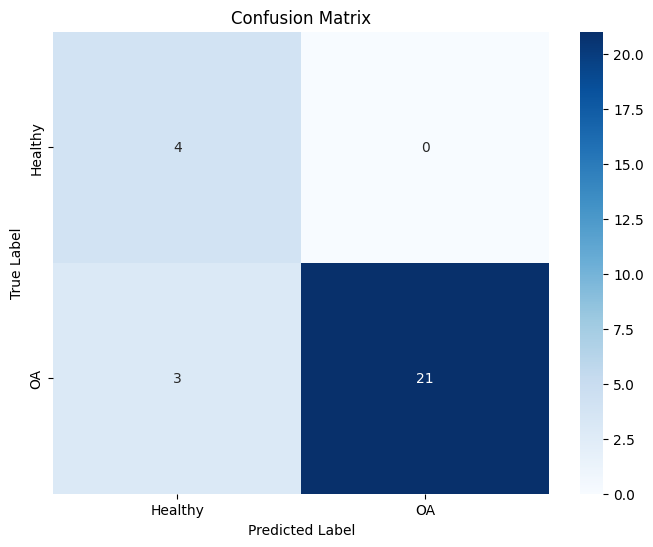

Test Accuracy: 100.00%, AUC: 1.0000

Testing: LR=0.02, L2=0.01, Architecture=[202, 128, 64, 32, 1]
=== Gait Waveform Classification with Deep Neural Network ===

Preprocessing data...
Training set: 110 examples
Test set: 28 examples
Features: 202

Network architecture: [202, 128, 64, 32, 1]
Learning rate: 0.02
Iterations: 1500
L2 regularization parameter: 0.01

Training model...
Cost after iteration 0: 0.784146
Cost after iteration 100: 0.147675
Cost after iteration 200: 0.094410
Cost after iteration 300: 0.069868
Cost after iteration 400: 0.055241
Cost after iteration 500: 0.046314
Cost after iteration 600: 0.039104
Cost after iteration 700: 0.033883
Cost after iteration 800: 0.030806
Cost after iteration 900: 0.028822
Cost after iteration 1000: 0.027421
Cost after iteration 1100: 0.026389
Cost after iteration 1200: 0.025602
Cost after iteration 1300: 0.024933
Cost after iteration 1400: 0.024418


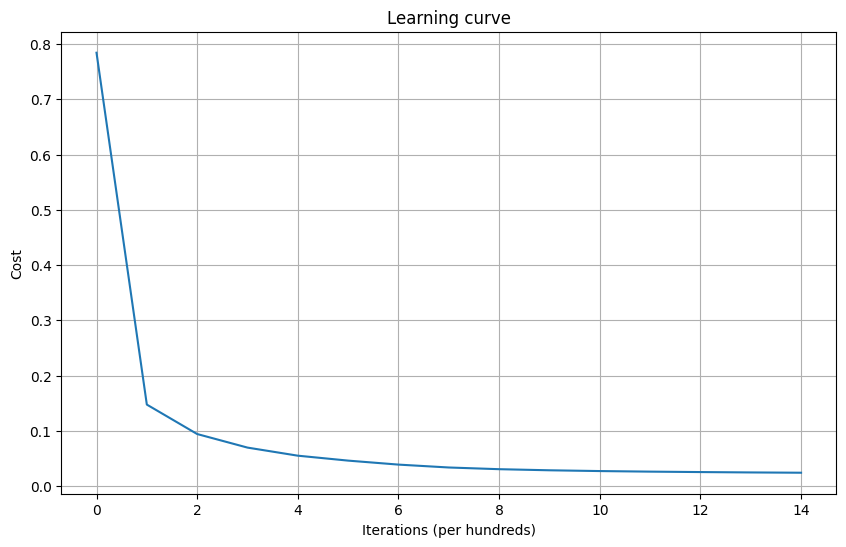


=== Training Set Performance ===
Training Accuracy: 100.00%
Training AUC: 1.0000

=== Test Set Performance ===
Test Accuracy: 89.29%
Test AUC: 0.9583

=== Detailed Classification Report ===
              precision    recall  f1-score   support

     Healthy       0.57      1.00      0.73         4
          OA       1.00      0.88      0.93        24

    accuracy                           0.89        28
   macro avg       0.79      0.94      0.83        28
weighted avg       0.94      0.89      0.90        28



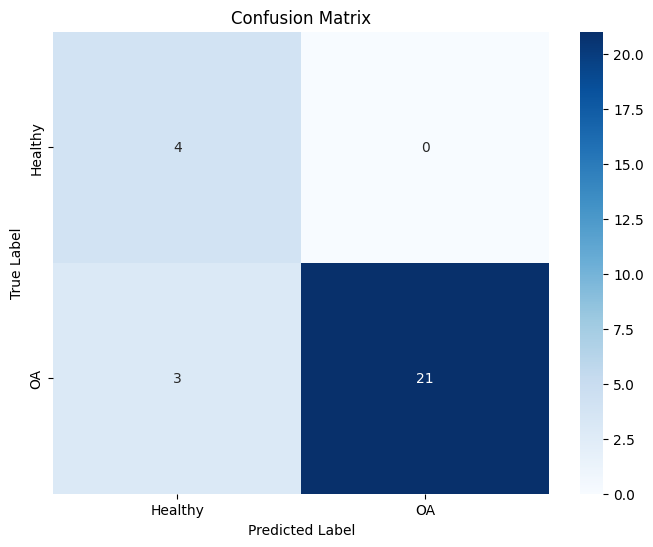

Test Accuracy: 100.00%, AUC: 1.0000

Testing: LR=0.02, L2=0.01, Architecture=[202, 128, 64, 32, 16, 1]
=== Gait Waveform Classification with Deep Neural Network ===

Preprocessing data...
Training set: 110 examples
Test set: 28 examples
Features: 202

Network architecture: [202, 128, 64, 32, 16, 1]
Learning rate: 0.02
Iterations: 1500
L2 regularization parameter: 0.01

Training model...
Cost after iteration 0: 0.880179
Cost after iteration 100: 0.108870
Cost after iteration 200: 0.061835
Cost after iteration 300: 0.047145
Cost after iteration 400: 0.037556
Cost after iteration 500: 0.032295
Cost after iteration 600: 0.029497
Cost after iteration 700: 0.027839
Cost after iteration 800: 0.026751
Cost after iteration 900: 0.025982
Cost after iteration 1000: 0.025425
Cost after iteration 1100: 0.024989
Cost after iteration 1200: 0.024646
Cost after iteration 1300: 0.024371
Cost after iteration 1400: 0.024145


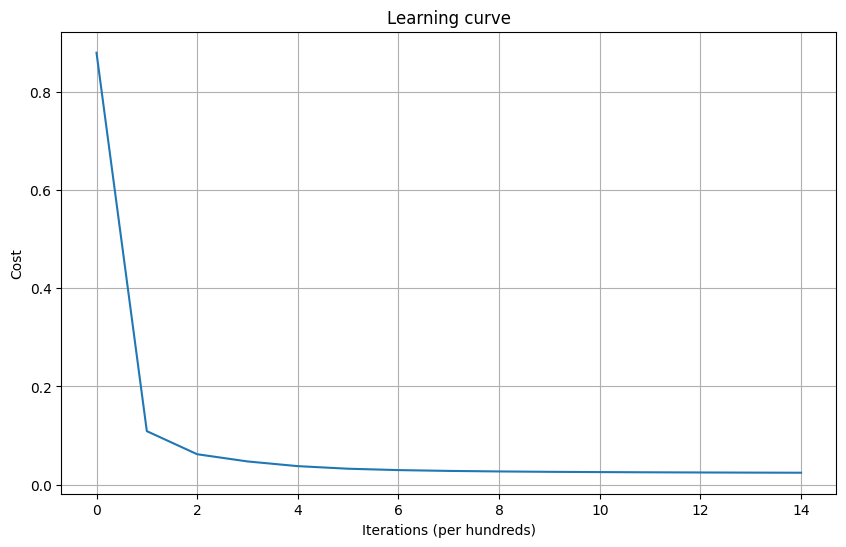


=== Training Set Performance ===
Training Accuracy: 100.00%
Training AUC: 1.0000

=== Test Set Performance ===
Test Accuracy: 89.29%
Test AUC: 0.9688

=== Detailed Classification Report ===
              precision    recall  f1-score   support

     Healthy       0.57      1.00      0.73         4
          OA       1.00      0.88      0.93        24

    accuracy                           0.89        28
   macro avg       0.79      0.94      0.83        28
weighted avg       0.94      0.89      0.90        28



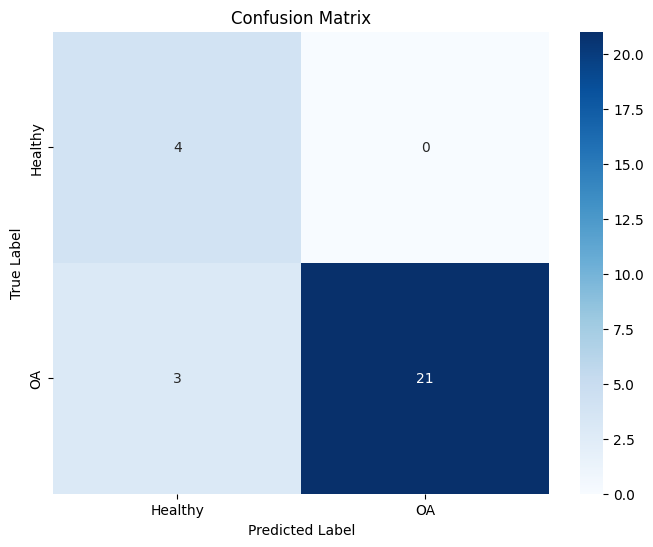

Test Accuracy: 100.00%, AUC: 1.0000

Testing: LR=0.02, L2=0.05, Architecture=[202, 128, 64, 1]
=== Gait Waveform Classification with Deep Neural Network ===

Preprocessing data...
Training set: 110 examples
Test set: 28 examples
Features: 202

Network architecture: [202, 128, 64, 1]
Learning rate: 0.02
Iterations: 1500
L2 regularization parameter: 0.05

Training model...
Cost after iteration 0: 0.759988
Cost after iteration 100: 0.229153
Cost after iteration 200: 0.183076
Cost after iteration 300: 0.156955
Cost after iteration 400: 0.140326
Cost after iteration 500: 0.128568
Cost after iteration 600: 0.120041
Cost after iteration 700: 0.113862
Cost after iteration 800: 0.109159
Cost after iteration 900: 0.105563
Cost after iteration 1000: 0.102845
Cost after iteration 1100: 0.100711
Cost after iteration 1200: 0.098982
Cost after iteration 1300: 0.097576
Cost after iteration 1400: 0.096413


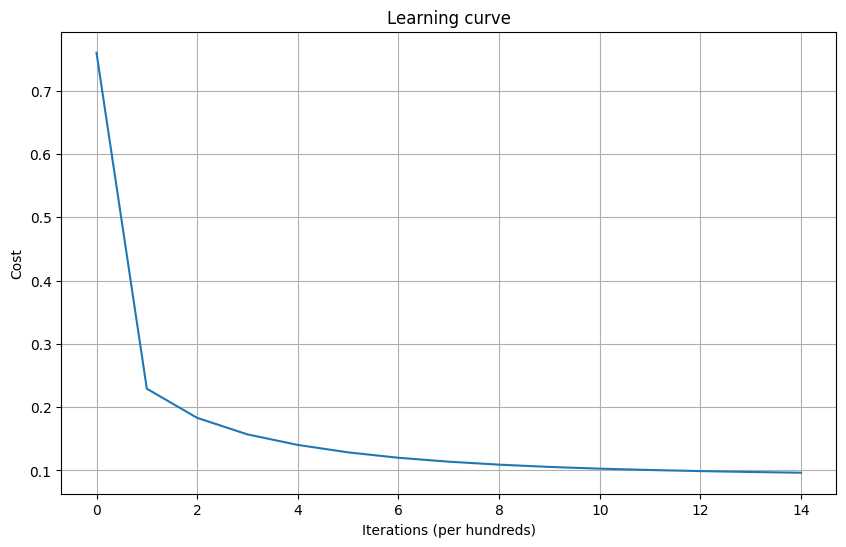


=== Training Set Performance ===
Training Accuracy: 100.00%
Training AUC: 1.0000

=== Test Set Performance ===
Test Accuracy: 89.29%
Test AUC: 0.9062

=== Detailed Classification Report ===
              precision    recall  f1-score   support

     Healthy       0.57      1.00      0.73         4
          OA       1.00      0.88      0.93        24

    accuracy                           0.89        28
   macro avg       0.79      0.94      0.83        28
weighted avg       0.94      0.89      0.90        28



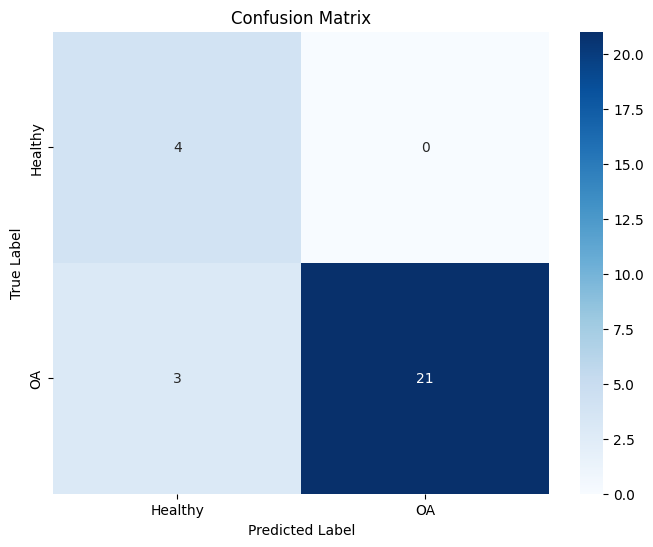

Test Accuracy: 100.00%, AUC: 1.0000

Testing: LR=0.02, L2=0.05, Architecture=[202, 128, 64, 32, 1]
=== Gait Waveform Classification with Deep Neural Network ===

Preprocessing data...
Training set: 110 examples
Test set: 28 examples
Features: 202

Network architecture: [202, 128, 64, 32, 1]
Learning rate: 0.02
Iterations: 1500
L2 regularization parameter: 0.05

Training model...
Cost after iteration 0: 0.866536
Cost after iteration 100: 0.230432
Cost after iteration 200: 0.177268
Cost after iteration 300: 0.152852
Cost after iteration 400: 0.138220
Cost after iteration 500: 0.129227
Cost after iteration 600: 0.122085
Cost after iteration 700: 0.116655
Cost after iteration 800: 0.113434
Cost after iteration 900: 0.111302
Cost after iteration 1000: 0.109768
Cost after iteration 1100: 0.108598
Cost after iteration 1200: 0.107657
Cost after iteration 1300: 0.106847
Cost after iteration 1400: 0.106188


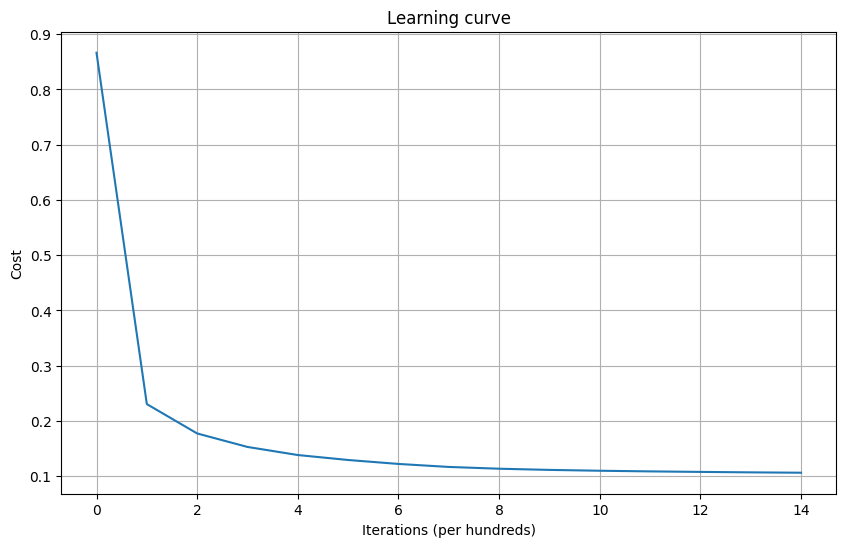


=== Training Set Performance ===
Training Accuracy: 100.00%
Training AUC: 1.0000

=== Test Set Performance ===
Test Accuracy: 89.29%
Test AUC: 0.9583

=== Detailed Classification Report ===
              precision    recall  f1-score   support

     Healthy       0.57      1.00      0.73         4
          OA       1.00      0.88      0.93        24

    accuracy                           0.89        28
   macro avg       0.79      0.94      0.83        28
weighted avg       0.94      0.89      0.90        28



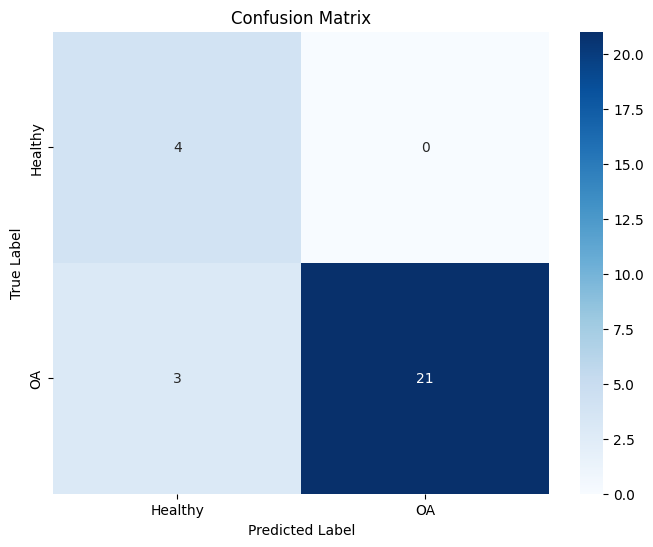

Test Accuracy: 100.00%, AUC: 1.0000

Testing: LR=0.02, L2=0.05, Architecture=[202, 128, 64, 32, 16, 1]
=== Gait Waveform Classification with Deep Neural Network ===

Preprocessing data...
Training set: 110 examples
Test set: 28 examples
Features: 202

Network architecture: [202, 128, 64, 32, 16, 1]
Learning rate: 0.02
Iterations: 1500
L2 regularization parameter: 0.05

Training model...
Cost after iteration 0: 0.968503
Cost after iteration 100: 0.197927
Cost after iteration 200: 0.150820
Cost after iteration 300: 0.135871
Cost after iteration 400: 0.126613
Cost after iteration 500: 0.120865
Cost after iteration 600: 0.117972
Cost after iteration 700: 0.116201
Cost after iteration 800: 0.114975
Cost after iteration 900: 0.114064
Cost after iteration 1000: 0.113356
Cost after iteration 1100: 0.112766
Cost after iteration 1200: 0.112263
Cost after iteration 1300: 0.111827
Cost after iteration 1400: 0.111438


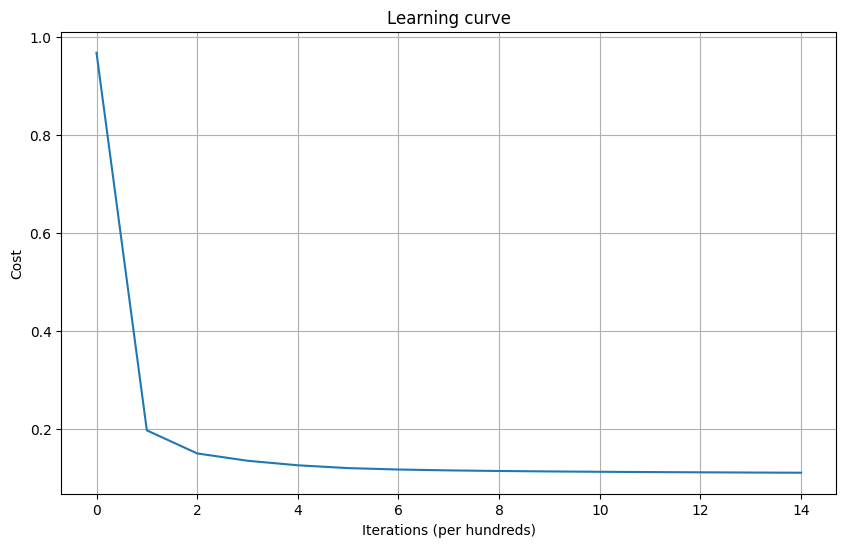


=== Training Set Performance ===
Training Accuracy: 100.00%
Training AUC: 1.0000

=== Test Set Performance ===
Test Accuracy: 89.29%
Test AUC: 0.9792

=== Detailed Classification Report ===
              precision    recall  f1-score   support

     Healthy       0.57      1.00      0.73         4
          OA       1.00      0.88      0.93        24

    accuracy                           0.89        28
   macro avg       0.79      0.94      0.83        28
weighted avg       0.94      0.89      0.90        28



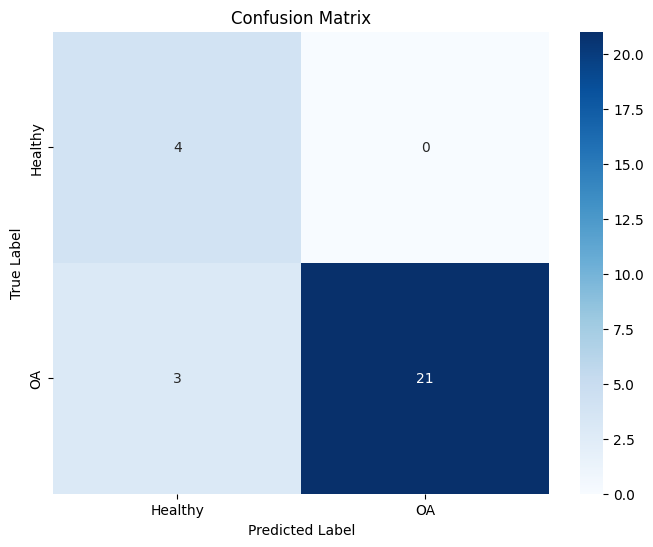

Test Accuracy: 100.00%, AUC: 1.0000

=== Best Parameters Found ===
Best Test Accuracy: 100.00%
Best Parameters: {'learning_rate': 0.005, 'lambda': 0.0, 'architecture': [202, 128, 64, 32, 16, 1], 'test_accuracy': np.float64(100.0), 'test_auc': np.float64(1.0)}

### STEP 4: Gait Pattern Analysis ###

=== Gait Pattern Analysis ===


C:\Users\nloug\AppData\Local\Temp\ipykernel_50004\3268833734.py:21: RuntimeWarning: Mean of empty slice.
  healthy_avg = X_train_scaled[healthy_mask].mean(axis=0)
c:\Users\nloug\OneDrive - University of Waterloo\DeepLearningAI Coursera\.venv\Lib\site-packages\numpy\_core\_methods.py:137: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\nloug\AppData\Local\Temp\ipykernel_50004\3268833734.py:22: RuntimeWarning: Mean of empty slice.
  oa_avg = X_train_scaled[oa_mask].mean(axis=0)


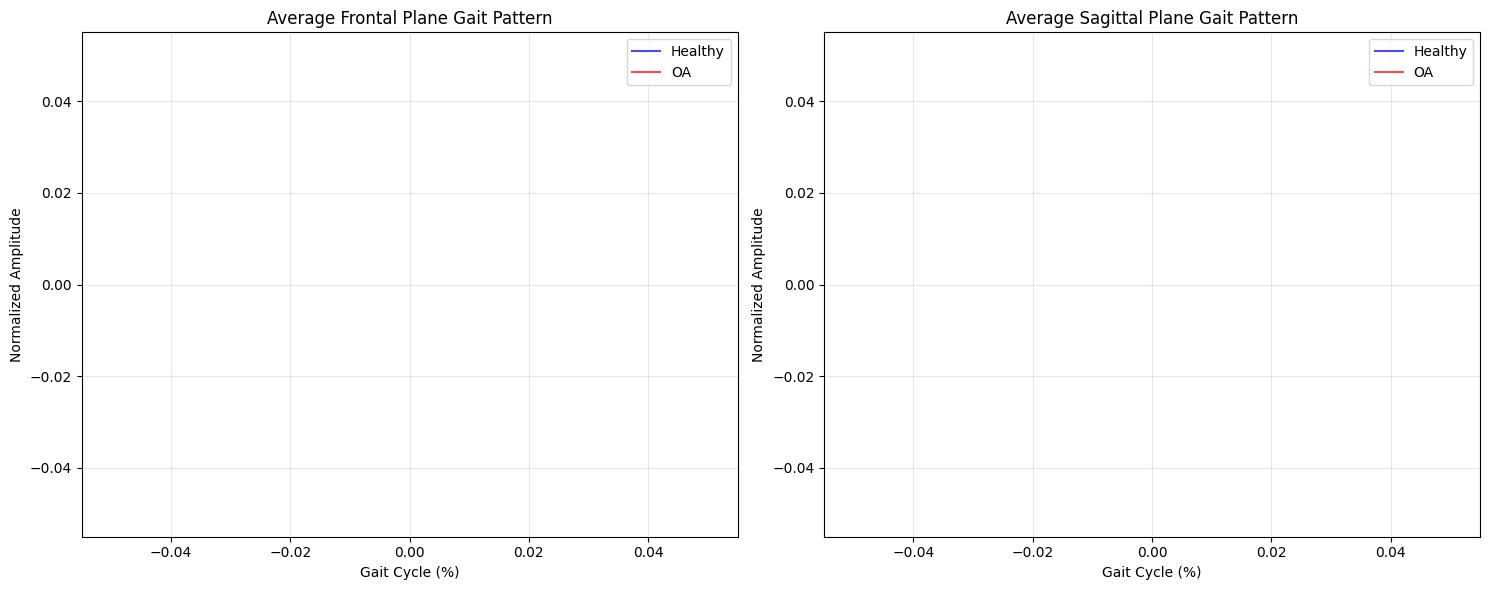

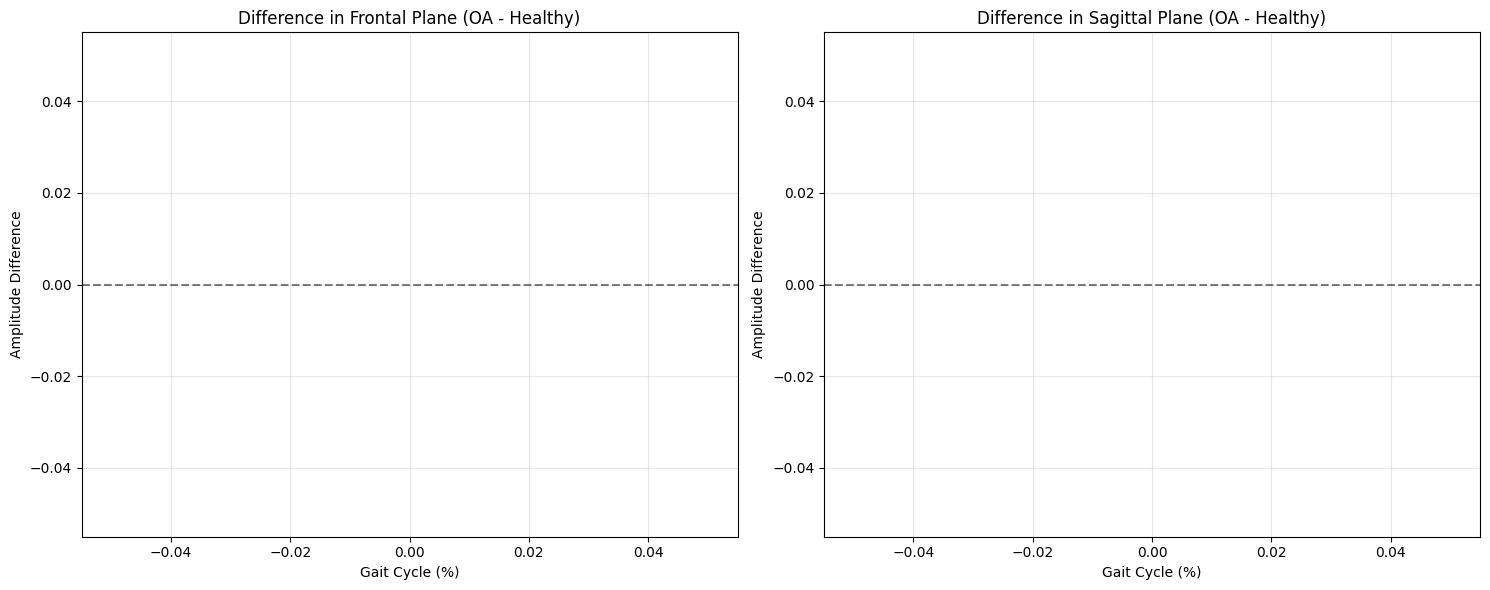


### STEP 5: Final Report ###

           GAIT WAVEFORM CLASSIFICATION REPORT

MODEL ARCHITECTURE:
  - Number of layers: 5
  - Input features: 202
  - Hidden layer 1: 128 neurons
  - Hidden layer 2: 64 neurons
  - Hidden layer 3: 32 neurons
  - Hidden layer 4: 16 neurons
  - Output layer: 1 neuron(s)

TRAINING PERFORMANCE:
  - Final training cost: 0.024402
  - Training converged: Yes

TEST PERFORMANCE:
  - Test Accuracy: 89.29%
  - Test AUC: 0.9792

CROSS-VALIDATION RESULTS:
  - Mean CV Accuracy: 100.00% ± 0.00%
  - Mean CV AUC: 1.0000 ± 0.0000

FEATURE IMPORTANCE:
  - Average frontal plane importance: 0.0793
  - Average sagittal plane importance: 0.0790
  - Most important plane: Frontal

TOP 5 MOST IMPORTANT FEATURES:
  174. Y_73 (Sagittal plane, 73% gait cycle) - 0.0944
  183. Y_81 (Sagittal plane, 81% gait cycle) - 0.0921
  65. X_66 (Frontal plane, 66% gait cycle) - 0.0912
  126. Y_3 (Sagittal plane, 3% gait cycle) - 0.0905
  187. Y_85 (Sagittal plane, 85% gait cycle) - 0.0886


Ana

In [ ]:
# Main Execution 
if __name__ == "__main__":
    """
    Main execution script - run this to perform complete analysis
    """
    
    print("Starting Gait Waveform Classification Analysis...")
    
    # Step 1: Basic model training
    print("\n### STEP 1: Basic Model Training ###")
    parameters, scaler, costs, importance_df = run_gait_classification_pipeline()
    
    # Step 2: Cross-validation
    print("\n### STEP 2: Cross-Validation ###")
    cv_accuracies, cv_aucs = cross_validate_model(n_splits=5)
    
    # Step 3: Hyperparameter search (optional - takes longer)
    # print("\n### STEP 3: Hyperparameter Search ###")
    # results_df, best_params = hyperparameter_search()
    
    # Step 4: Gait pattern analysis
    print("\n### STEP 4: Gait Pattern Analysis ###")
    healthy_avg, oa_avg, diff_frontal, diff_sagittal = analyze_gait_patterns(
        parameters, scaler, X_train, y_train
    )
    
    # Step 5: Generate comprehensive report
    print("\n### STEP 5: Final Report ###")
    
    # Get test performance
    X_train_proc, X_test_proc, y_train_proc, y_test_proc, _ = preprocess_gait_data(
        X_train, X_test, y_train, y_test
    )
    test_accuracy, test_auc, _, _ = evaluate_model(X_test_proc, y_test_proc, parameters)
    
    generate_model_report(
        parameters, scaler, costs, importance_df, 
        test_accuracy, test_auc, 
        cv_results=(cv_accuracies, cv_aucs)
    )
    
    print("\nAnalysis complete! Check the plots and reports above.")
    print("Model parameters and scaler have been saved for future predictions.")